****
# Introduction 🥸
****
*Author: Samanyu K*<br>
*Language: Python*<br>
*GPU: None*

**Goal: The goal of this project is to develop a Machine Learning model that predicts daily water consumption for individual households based on historical usage patterns, household characteristics, weather conditions, and conservation behaviors.**

****
# Overview 📚
****

**This notebook builds a machine learning pipeline for Water Consumption Prediction using an ensemble of CatBoost, LightGBM, and ElasticNet. The model blending approach aims to improve predictive performance by combining multiple models.**

1. Data Preprocessing

The preprocess_data() function prepares the dataset by Removing outliers using the Interquartile Range (IQR) method.Handling missing values by replacing infinities with NaNs and imputing missing values with the median.Scaling features using StandardScaler to normalize the numerical inputs. Applying log transformation (np.log1p) to stabilize the target variable's distribution.

2. Model Training & Hyperparameter Tuning
   
We train and tune three different models using Optuna for hyperparameter optimization:
CatBoostRegressor (catboost_objective)
LightGBMRegressor (lgbm_objective)
ElasticNet (elastic_objective)

Each objective function:
Uses Optuna to explore the best hyperparameters.
Runs K-Fold Cross Validation (CV) to evaluate model performance.
Minimizes the Mean Squared Error (MSE) as the optimization metric.

3. Model Blending

Instead of using a single model, we blend CatBoost and LightGBM predictions using an optimized weighted sum approach:
The function optimize_blend() determines the optimal blend weights (w_cat, w_lgb) by minimizing the Mean Squared Error (MSE).

The final blended prediction is computed as:
blend_oof=𝑤cat×cat_oof+𝑤lgb×lgb_oof
Residual errors (differences between actual and blended predictions) are modeled separately using ElasticNet, a linear regression with L1 & L2 regularization.

4. Final Predictions

The final prediction combines the blended model output with the residual correction from ElasticNet:
Final Prediction=blend+residual
The np.expm1() function is applied to revert the log-transformed predictions back to the original scale.

6. Model Evaluation & Feature Importance

The Mean Squared Error (MSE) is calculated for:
CatBoost alone
LightGBM alone
Blended model (CatBoost + LightGBM)
Final model (Blended + ElasticNet residuals)
Feature importance is extracted from CatBoost to understand which features contribute most to predictions.

8. Saving & Submitting Results

The Out-of-Fold (OOF) predictions and feature importance are saved as CSV files.
The final predictions for test data are stored in submission.csv for Kaggle submission.

****
# Reading and Displaying Data 📖
****

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv(r"/kaggle/input/hackerearth-comp/dataset/train.csv")
te=pd.read_csv(r"/kaggle/input/hackerearth-comp/dataset/test.csv")
tte=te.copy()
df

,Timestamp,Residents,Apartment_Type,Temperature,Humidity,Water_Price,Period_Consumption_Index,Income_Level,Guests,Amenities,Appliance_Usage,Water_Consumption
0,01/01/2002 00,1,Studio,15.31,46.61,1.06,0.970000,Low,0,Swimming Pool,0.0,64.85
1,01/01/2002 08,4,NaN,21.01,66.11,2.98,0.910000,Upper Middle,1,Swimming Pool,1.0,192.50
2,01/01/2002 16,2,Cottage,12.86,60.86,1.44,1.430000,Middle,0,NaN,1.0,116.62
3,02/01/2002 00,2,1BHK,20.16,50.58,1.48,0.910000,Middle,-1,Garden,0.0,76.96
4,02/01/2002 08,2,Cottage,16.23,52.25,1.14,1.110000,Middle,0,Fountain,0.0,104.70
...,...,...,...,...,...,...,...,...,...,...,...,...
13995,10/10/2014 00,2,1BHK,25.61,61.5,1.70,0.940000,Low,0,NaN,0.0,78.59
13996,10/10/2014 08,5,2BHK,13.27,52.58,1.88,1.030000,Upper Middle,0,Garden,1.0,185.50
13997,10/10/2014 16,4,2BHK,NaN,46.93,1.22,1.100000,Middle,0,NaN,1.0,180.28
13998,11/10/2014 00,4,3BHK,11.62,64.48,2.86,1.120000,Upper Middle,1,Swimming Pool,0.0,212.19


****
# Data Preprocessing ⚙️
****

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Timestamp                 14000 non-null  object 
 1   Residents                 14000 non-null  int64  
 2   Apartment_Type            13574 non-null  object 
 3   Temperature               13559 non-null  float64
 4   Humidity                  14000 non-null  object 
 5   Water_Price               14000 non-null  float64
 6   Period_Consumption_Index  14000 non-null  float64
 7   Income_Level              13574 non-null  object 
 8   Guests                    14000 non-null  int64  
 9   Amenities                 8003 non-null   object 
 10  Appliance_Usage           13585 non-null  float64
 11  Water_Consumption         14000 non-null  float64
dtypes: float64(5), int64(2), object(5)
memory usage: 1.3+ MB


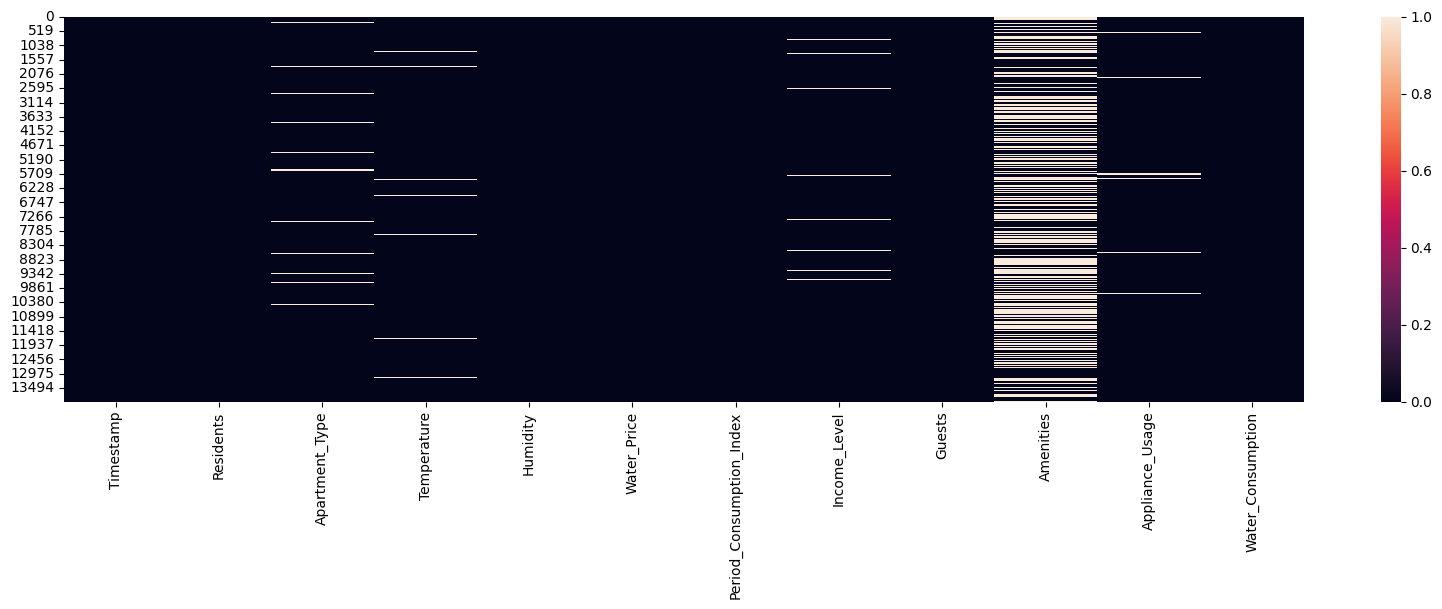

In [4]:
#null values
plt.figure(figsize=(20,5))
sns.heatmap(df.isnull())
plt.show()

In [5]:
df['Appliance_Usage'].value_counts()

Appliance_Usage
0.0    10841
1.0     2744
Name: count, dtype: int64

In [6]:
df['Income_Level'].value_counts()

Income_Level
Middle          5323
Upper Middle    3966
Low             2276
Rich            1593
z3>8{              1
                ... 
|8*CE              1
a(rZg              1
=7|+4              1
j~+x!              1
c&8%1              1
Name: count, Length: 420, dtype: int64

In [7]:
import category_encoders as ce
import pandas as pd

apt_type_medians = df.groupby('Apartment_Type')['Water_Consumption'].median()
overall_median = df['Water_Consumption'].median()
df['Apartment_Type'] = df['Apartment_Type'].map(apt_type_medians).fillna(overall_median)

app_usage_medians = df.groupby('Appliance_Usage')['Water_Consumption'].median()
df['Appliance_Usage'] = df['Appliance_Usage'].map(app_usage_medians).fillna(overall_median)

df['Temperature'] = df['Temperature'].fillna(df['Temperature'].median())

def replace_invalid(value):
    if pd.isna(value) or not isinstance(value, str) or not value.replace(' ', '').isalnum():
        return ''
    return value

df['Income_Level'] = df['Income_Level'].apply(replace_invalid)
income_level_medians = df.groupby('Income_Level')['Water_Consumption'].median()
df['Income_Level'] = df['Income_Level'].map(income_level_medians)

amenities_medians = df.groupby('Amenities')['Water_Consumption'].median()
df['Amenities'] = df['Amenities'].map(amenities_medians).fillna(overall_median)

te['Apartment_Type'] = te['Apartment_Type'].map(apt_type_medians).fillna(overall_median)
te['Appliance_Usage'] = te['Appliance_Usage'].map(app_usage_medians).fillna(overall_median)
te['Temperature'] = te['Temperature'].fillna(df['Temperature'].median())
te['Income_Level'] = te['Income_Level'].apply(replace_invalid)
te['Income_Level'] = te['Income_Level'].map(income_level_medians).fillna(overall_median)
te['Amenities'] = te['Amenities'].map(amenities_medians).fillna(overall_median)

def clean(val):
    try:
        return float(val)
    except (ValueError, TypeError):
        return None
df['Humidity']=df['Humidity'].apply(clean)
df['Humidity']=df['Humidity'].fillna(df['Humidity'].median())
te['Humidity']=te['Humidity'].apply(clean)
te['Humidity']=te['Humidity'].fillna(te['Humidity'].median())

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Timestamp                 14000 non-null  object 
 1   Residents                 14000 non-null  int64  
 2   Apartment_Type            14000 non-null  float64
 3   Temperature               14000 non-null  float64
 4   Humidity                  14000 non-null  float64
 5   Water_Price               14000 non-null  float64
 6   Period_Consumption_Index  14000 non-null  float64
 7   Income_Level              14000 non-null  float64
 8   Guests                    14000 non-null  int64  
 9   Amenities                 14000 non-null  float64
 10  Appliance_Usage           14000 non-null  float64
 11  Water_Consumption         14000 non-null  float64
dtypes: float64(9), int64(2), object(1)
memory usage: 1.3+ MB


In [9]:
te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Timestamp                 6000 non-null   object 
 1   Residents                 6000 non-null   int64  
 2   Apartment_Type            6000 non-null   float64
 3   Temperature               6000 non-null   float64
 4   Humidity                  6000 non-null   float64
 5   Water_Price               6000 non-null   float64
 6   Period_Consumption_Index  6000 non-null   float64
 7   Income_Level              6000 non-null   float64
 8   Guests                    6000 non-null   int64  
 9   Amenities                 6000 non-null   float64
 10  Appliance_Usage           6000 non-null   float64
dtypes: float64(8), int64(2), object(1)
memory usage: 515.8+ KB


In [10]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H')
df['day'] = df['Timestamp'].dt.day
df['month'] = df['Timestamp'].dt.month
df['year'] = df['Timestamp'].dt.year
df['hour'] = df['Timestamp'].dt.hour

te['Timestamp'] = pd.to_datetime(te['Timestamp'], format='%d/%m/%Y %H')
te['day'] = te['Timestamp'].dt.day
te['month'] = te['Timestamp'].dt.month
te['year'] = te['Timestamp'].dt.year
te['hour'] = te['Timestamp'].dt.hour
df.drop(columns='Timestamp',inplace=True)
te.drop(columns='Timestamp',inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Residents                 14000 non-null  int64  
 1   Apartment_Type            14000 non-null  float64
 2   Temperature               14000 non-null  float64
 3   Humidity                  14000 non-null  float64
 4   Water_Price               14000 non-null  float64
 5   Period_Consumption_Index  14000 non-null  float64
 6   Income_Level              14000 non-null  float64
 7   Guests                    14000 non-null  int64  
 8   Amenities                 14000 non-null  float64
 9   Appliance_Usage           14000 non-null  float64
 10  Water_Consumption         14000 non-null  float64
 11  day                       14000 non-null  int32  
 12  month                     14000 non-null  int32  
 13  year                      14000 non-null  int32  
 14  hour  

In [12]:
te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Residents                 6000 non-null   int64  
 1   Apartment_Type            6000 non-null   float64
 2   Temperature               6000 non-null   float64
 3   Humidity                  6000 non-null   float64
 4   Water_Price               6000 non-null   float64
 5   Period_Consumption_Index  6000 non-null   float64
 6   Income_Level              6000 non-null   float64
 7   Guests                    6000 non-null   int64  
 8   Amenities                 6000 non-null   float64
 9   Appliance_Usage           6000 non-null   float64
 10  day                       6000 non-null   int32  
 11  month                     6000 non-null   int32  
 12  year                      6000 non-null   int32  
 13  hour                      6000 non-null   int32  
dtypes: float

****
# Feature Engineering 🧑‍🔬
****
**This notebook does not show any new features**<br>
**This section only shows the correlaton matrix visualized and Calculation of Mutual Information and visualizzation of that**

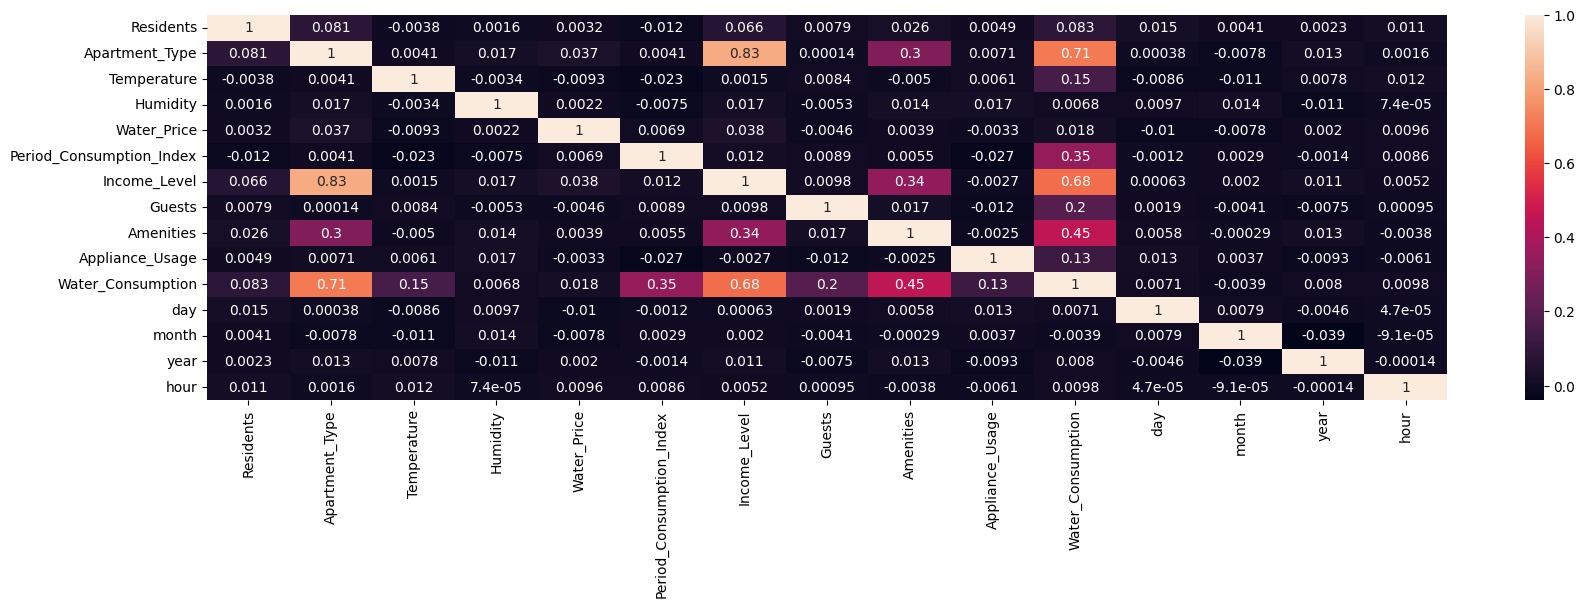

In [13]:
plt.figure(figsize=(20,5))
sns.heatmap(df.corr(),annot=True)
plt.show()

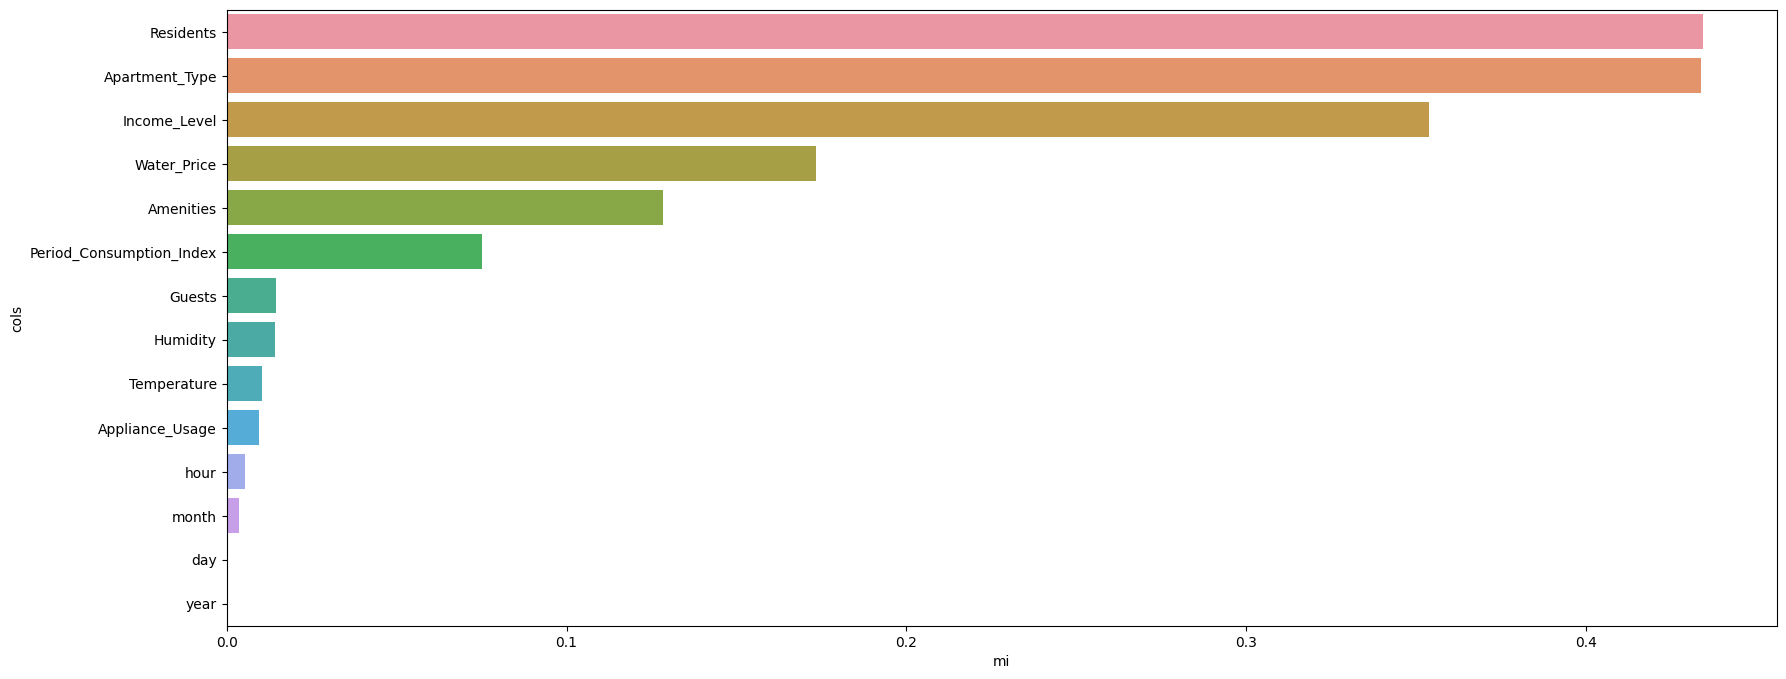

In [14]:
from sklearn.feature_selection import mutual_info_regression
x=df.drop(columns='Water_Consumption')
y=df['Water_Consumption']
mi=mutual_info_regression(x,y)
mi_df=pd.DataFrame({'cols':x.columns,'mi':mi})
mi_df.sort_values(by='mi',inplace=True,ascending=False)
plt.figure(figsize=(20,8))
sns.barplot(data=mi_df,x='mi',y='cols')
plt.show()

****
# Model and HyperParameter Tuning 🪄
****

In [15]:
import pandas as pd
import numpy as np
import optuna
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
from tqdm import tqdm

def tune_model(objective, n_trials, direction='minimize'):
    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, n_jobs=-1, callbacks=[lambda study, trial: tqdm.write(f"Trial {trial.number} finished")])
    return study.best_params


def preprocess_data(df, te, target_col='Water_Consumption'):
    Q1 = df[target_col].quantile(0.25)
    Q3 = df[target_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df[(df[target_col] >= lower_bound) & (df[target_col] <= upper_bound)].copy()
    print(f"Rows after outlier removal: {df_cleaned.shape[0]} (original: {df.shape[0]})")

    df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan)
    te_cleaned = te.replace([np.inf, -np.inf], np.nan)
    
    imputer = SimpleImputer(strategy='median')
    X = pd.DataFrame(imputer.fit_transform(df_cleaned.drop(columns=target_col)), columns=df_cleaned.drop(columns=target_col).columns).astype('float32')
    y = np.log1p(df_cleaned[target_col].astype('float32'))  
    X_test = pd.DataFrame(imputer.transform(te_cleaned), columns=te_cleaned.columns).astype('float32')
   
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    return X, y, X_test


def catboost_objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'iterations': trial.suggest_int('iterations', 500, 2000),  
        'depth': trial.suggest_int('depth', 4, 8),
        'border_count': trial.suggest_int('border_count', 32, 256),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'random_state': 42,
        'task_type': 'CPU',  
        'verbose': 0,
        'early_stopping_rounds': 50
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse = []
    cat = CatBoostRegressor(**params)
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        cat.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
        mse.append(mean_squared_error(y_val, cat.predict(X_val)))
    return np.mean(mse)


def lgbm_objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000), 
        'max_depth': trial.suggest_int('max_depth', -1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'verbose': -1
    }
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    mse = []
    lgb = LGBMRegressor(**params)
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        lgb.fit(X_train, y_train)
        mse.append(mean_squared_error(y_val, lgb.predict(X_val)))
    return np.mean(mse)


def elastic_objective(trial):
    alpha = trial.suggest_loguniform('alpha', 0.001, 1.0)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse = []
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        res_train, res_val = residuals.iloc[train_idx], residuals.iloc[val_idx]
        elastic.fit(X_train, res_train)
        mse.append(mean_squared_error(res_val, elastic.predict(X_val)))
    return np.mean(mse)

def optimize_blend(oof1, oof2, y_true):
    def blend_loss(weights, oof1, oof2, y_true):
        blend = weights[0] * oof1 + weights[1] * oof2
        return mean_squared_error(y_true, blend)
    result = minimize(
        blend_loss, [0.5, 0.5], args=(oof1, oof2, y_true),
        bounds=[(0, 1), (0, 1)], constraints={'type': 'eq', 'fun': lambda w: w[0] + w[1] - 1}
    )
    return result.x

X, y, X_test = preprocess_data(df, te)

best_cat_params = tune_model(catboost_objective, 100)
best_lgb_params = tune_model(lgbm_objective, 100)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
cat_oof = np.zeros(len(X))
lgb_oof = np.zeros(len(X))

cat = CatBoostRegressor(**best_cat_params, random_state=42, task_type='CPU', verbose=0, early_stopping_rounds=50)
lgb = LGBMRegressor(**best_lgb_params, random_state=42, verbose=-1)

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    cat.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    lgb.fit(X_train, y_train)
    cat_oof[val_idx] = cat.predict(X_val)
    lgb_oof[val_idx] = lgb.predict(X_val)

w_cat, w_lgb = optimize_blend(cat_oof, lgb_oof, y)
blend_oof = w_cat * cat_oof + w_lgb * lgb_oof

residuals = y - blend_oof
best_elastic_params = tune_model(elastic_objective, 50)
elastic = ElasticNet(**best_elastic_params, random_state=42)
elastic.fit(X, residuals)

cat.fit(X, y)
lgb.fit(X, y)
cat_te = cat.predict(X_test)
lgb_te = lgb.predict(X_test)
blend_te = w_cat * cat_te + w_lgb * lgb_te
residual_te = elastic.predict(X_test)
pred_log = blend_te + residual_te
pred = np.expm1(pred_log)  

cat_oof_orig = np.expm1(cat_oof)
lgb_oof_orig = np.expm1(lgb_oof)
blend_oof_orig = np.expm1(blend_oof)
y_orig = np.expm1(y)
cat_mse = mean_squared_error(y_orig, cat_oof_orig)
lgb_mse = mean_squared_error(y_orig, lgb_oof_orig)
blend_mse = mean_squared_error(y_orig, blend_oof_orig)
final_mse = mean_squared_error(y_orig, blend_oof_orig + np.expm1(elastic.predict(X)))

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': cat.get_feature_importance()
}).sort_values('Importance', ascending=False)

# Save intermediate results
pd.DataFrame({'True': y_orig, 'CatBoost': cat_oof_orig, 'LightGBM': lgb_oof_orig, 'Blend': blend_oof_orig}).to_csv('oof_predictions.csv', index=False)
feature_importance.to_csv('feature_importance.csv', index=False)
pd.DataFrame({'Timestamp': tte['Timestamp'], 'Water_Consumption': pred}).to_csv('submission.csv', index=False)

# Print results
print("Best CatBoost Params:", best_cat_params)
print("Best LightGBM Params:", best_lgb_params)
print("Best Elastic Net Params:", best_elastic_params)
print(f"Optimized Blend Weights: CatBoost={w_cat:.3f}, LightGBM={w_lgb:.3f}")
print(f"CatBoost CV MSE: {cat_mse:.4f}")
print(f"LightGBM CV MSE: {lgb_mse:.4f}")
print(f"Blended CV MSE (Before Residuals): {blend_mse:.4f}")
print(f"Final CV MSE (With Elastic Net Residuals): {final_mse:.4f}")
print("\nFeature Importance (CatBoost):")
print(feature_importance)
print("\nTest Predictions (Final, First 10):", pred[:10])

[I 2025-04-02 05:40:28,730] A new study created in memory with name: no-name-a0f9da8a-8c5d-4c0d-a3ce-b880eb1b52d5


Rows after outlier removal: 13763 (original: 14000)


[I 2025-04-02 05:40:43,821] Trial 2 finished with value: 0.0020716225575391654 and parameters: {'learning_rate': 0.27449377190133206, 'l2_leaf_reg': 8.305365608208975, 'iterations': 1809, 'depth': 6, 'border_count': 126, 'bagging_temperature': 0.23810697846639572, 'min_data_in_leaf': 23, 'grow_policy': 'SymmetricTree'}. Best is trial 2 with value: 0.0020716225575391654.


Trial 2 finished


[I 2025-04-02 05:41:09,624] Trial 4 finished with value: 0.003600140082893895 and parameters: {'learning_rate': 0.280585572539668, 'l2_leaf_reg': 2.969272251542212, 'iterations': 504, 'depth': 7, 'border_count': 245, 'bagging_temperature': 0.048094576581970694, 'min_data_in_leaf': 33, 'grow_policy': 'Depthwise'}. Best is trial 2 with value: 0.0020716225575391654.


Trial 4 finished


[I 2025-04-02 05:41:10,142] Trial 0 finished with value: 0.003575051191064926 and parameters: {'learning_rate': 0.02773821996545871, 'l2_leaf_reg': 9.238074781782439, 'iterations': 1005, 'depth': 8, 'border_count': 69, 'bagging_temperature': 0.6925506317555258, 'min_data_in_leaf': 18, 'grow_policy': 'SymmetricTree'}. Best is trial 2 with value: 0.0020716225575391654.


Trial 0 finished


[I 2025-04-02 05:41:21,142] Trial 3 finished with value: 0.0022626049111769578 and parameters: {'learning_rate': 0.11921478388388972, 'l2_leaf_reg': 2.25890606630653, 'iterations': 1785, 'depth': 4, 'border_count': 216, 'bagging_temperature': 0.801905797848949, 'min_data_in_leaf': 38, 'grow_policy': 'Lossguide'}. Best is trial 2 with value: 0.0020716225575391654.


Trial 3 finished


[I 2025-04-02 05:41:32,900] Trial 7 finished with value: 0.0019730335245998895 and parameters: {'learning_rate': 0.27121355504090494, 'l2_leaf_reg': 2.717781594655841, 'iterations': 1624, 'depth': 5, 'border_count': 225, 'bagging_temperature': 0.34822919112526685, 'min_data_in_leaf': 11, 'grow_policy': 'SymmetricTree'}. Best is trial 7 with value: 0.0019730335245998895.


Trial 7 finished


[I 2025-04-02 05:41:42,375] Trial 6 finished with value: 0.0030434076672099146 and parameters: {'learning_rate': 0.18357267172887423, 'l2_leaf_reg': 4.297437378186756, 'iterations': 798, 'depth': 7, 'border_count': 164, 'bagging_temperature': 0.30152302689548494, 'min_data_in_leaf': 37, 'grow_policy': 'Depthwise'}. Best is trial 7 with value: 0.0019730335245998895.


Trial 6 finished


[I 2025-04-02 05:41:58,328] Trial 5 finished with value: 0.0020516063929756807 and parameters: {'learning_rate': 0.041754747305444546, 'l2_leaf_reg': 6.948952266757206, 'iterations': 1096, 'depth': 7, 'border_count': 214, 'bagging_temperature': 0.5613382190944183, 'min_data_in_leaf': 39, 'grow_policy': 'SymmetricTree'}. Best is trial 7 with value: 0.0019730335245998895.


Trial 5 finished


[I 2025-04-02 05:42:10,348] Trial 8 finished with value: 0.003917107894285168 and parameters: {'learning_rate': 0.05666763781184336, 'l2_leaf_reg': 4.931099105888317, 'iterations': 1983, 'depth': 6, 'border_count': 52, 'bagging_temperature': 0.8920312080681247, 'min_data_in_leaf': 37, 'grow_policy': 'Lossguide'}. Best is trial 7 with value: 0.0019730335245998895.


Trial 8 finished


[I 2025-04-02 05:42:12,956] Trial 1 finished with value: 0.0021319157042147376 and parameters: {'learning_rate': 0.023422837482641953, 'l2_leaf_reg': 7.589467216141224, 'iterations': 1920, 'depth': 4, 'border_count': 234, 'bagging_temperature': 0.7642819137438593, 'min_data_in_leaf': 11, 'grow_policy': 'Lossguide'}. Best is trial 7 with value: 0.0019730335245998895.


Trial 1 finished


[I 2025-04-02 05:42:20,048] Trial 10 finished with value: 0.005049937611154724 and parameters: {'learning_rate': 0.1581006349456612, 'l2_leaf_reg': 5.298459207349256, 'iterations': 1728, 'depth': 7, 'border_count': 32, 'bagging_temperature': 0.8085253568272066, 'min_data_in_leaf': 40, 'grow_policy': 'Lossguide'}. Best is trial 7 with value: 0.0019730335245998895.


Trial 10 finished


[I 2025-04-02 05:42:21,890] Trial 12 finished with value: 0.003388302215699483 and parameters: {'learning_rate': 0.11831047363715592, 'l2_leaf_reg': 9.724014342809829, 'iterations': 1275, 'depth': 4, 'border_count': 59, 'bagging_temperature': 0.47350100509644744, 'min_data_in_leaf': 6, 'grow_policy': 'SymmetricTree'}. Best is trial 7 with value: 0.0019730335245998895.


Trial 12 finished


[I 2025-04-02 05:42:38,670] Trial 9 finished with value: 0.0022162751412340793 and parameters: {'learning_rate': 0.04956190390321511, 'l2_leaf_reg': 1.1826384816979463, 'iterations': 827, 'depth': 5, 'border_count': 161, 'bagging_temperature': 0.6302261937476845, 'min_data_in_leaf': 47, 'grow_policy': 'Lossguide'}. Best is trial 7 with value: 0.0019730335245998895.


Trial 9 finished


[I 2025-04-02 05:42:50,332] Trial 14 finished with value: 0.0018747989403845547 and parameters: {'learning_rate': 0.05260359296354475, 'l2_leaf_reg': 1.040751417040525, 'iterations': 1414, 'depth': 5, 'border_count': 186, 'bagging_temperature': 0.5411123915011187, 'min_data_in_leaf': 50, 'grow_policy': 'SymmetricTree'}. Best is trial 14 with value: 0.0018747989403845547.


Trial 14 finished


[I 2025-04-02 05:42:58,869] Trial 13 finished with value: 0.0023987966313834793 and parameters: {'learning_rate': 0.011158271336843854, 'l2_leaf_reg': 1.0981138743487369, 'iterations': 1451, 'depth': 5, 'border_count': 166, 'bagging_temperature': 0.3804851142599956, 'min_data_in_leaf': 3, 'grow_policy': 'SymmetricTree'}. Best is trial 14 with value: 0.0018747989403845547.


Trial 13 finished


[I 2025-04-02 05:43:16,189] Trial 15 finished with value: 0.002671777061754678 and parameters: {'learning_rate': 0.010722054560543828, 'l2_leaf_reg': 6.831426457157805, 'iterations': 1436, 'depth': 5, 'border_count': 201, 'bagging_temperature': 0.46746328988726726, 'min_data_in_leaf': 1, 'grow_policy': 'SymmetricTree'}. Best is trial 14 with value: 0.0018747989403845547.


Trial 15 finished


[I 2025-04-02 05:43:27,923] Trial 17 finished with value: 0.0018787498550340317 and parameters: {'learning_rate': 0.07348535539260842, 'l2_leaf_reg': 3.1039776910774224, 'iterations': 1477, 'depth': 5, 'border_count': 192, 'bagging_temperature': 0.13389362937586402, 'min_data_in_leaf': 50, 'grow_policy': 'SymmetricTree'}. Best is trial 14 with value: 0.0018747989403845547.


Trial 17 finished


[I 2025-04-02 05:43:31,012] Trial 11 finished with value: 0.0023852411959180727 and parameters: {'learning_rate': 0.03270160831491978, 'l2_leaf_reg': 1.5822281421277833, 'iterations': 1225, 'depth': 5, 'border_count': 99, 'bagging_temperature': 0.5666916455417542, 'min_data_in_leaf': 13, 'grow_policy': 'Lossguide'}. Best is trial 14 with value: 0.0018747989403845547.
[I 2025-04-02 05:43:31,190] Trial 16 finished with value: 0.0023643609468064785 and parameters: {'learning_rate': 0.011503064763569408, 'l2_leaf_reg': 1.3918131917250804, 'iterations': 1475, 'depth': 5, 'border_count': 189, 'bagging_temperature': 0.3349278587341252, 'min_data_in_leaf': 15, 'grow_policy': 'SymmetricTree'}. Best is trial 14 with value: 0.0018747989403845547.


Trial 11 finished
Trial 16 finished


[I 2025-04-02 05:43:38,498] Trial 18 finished with value: 0.0019770768710546845 and parameters: {'learning_rate': 0.07550402267934654, 'l2_leaf_reg': 3.3402516795259474, 'iterations': 1542, 'depth': 5, 'border_count': 123, 'bagging_temperature': 0.15222593851870025, 'min_data_in_leaf': 15, 'grow_policy': 'SymmetricTree'}. Best is trial 14 with value: 0.0018747989403845547.


Trial 18 finished


[I 2025-04-02 05:43:58,457] Trial 19 finished with value: 0.0019892718821955552 and parameters: {'learning_rate': 0.07130432181328018, 'l2_leaf_reg': 3.8319201259916698, 'iterations': 1505, 'depth': 6, 'border_count': 127, 'bagging_temperature': 0.015204443673843993, 'min_data_in_leaf': 50, 'grow_policy': 'SymmetricTree'}. Best is trial 14 with value: 0.0018747989403845547.


Trial 19 finished


[I 2025-04-02 05:44:15,502] Trial 21 finished with value: 0.002477959400375667 and parameters: {'learning_rate': 0.0768439049469505, 'l2_leaf_reg': 3.7554080119123396, 'iterations': 1534, 'depth': 6, 'border_count': 125, 'bagging_temperature': 0.11326288756279891, 'min_data_in_leaf': 49, 'grow_policy': 'Depthwise'}. Best is trial 14 with value: 0.0018747989403845547.


Trial 21 finished


[I 2025-04-02 05:44:26,328] Trial 20 finished with value: 0.0023673321418712224 and parameters: {'learning_rate': 0.07663082410450633, 'l2_leaf_reg': 3.559505409407649, 'iterations': 1516, 'depth': 6, 'border_count': 188, 'bagging_temperature': 0.1183615533142588, 'min_data_in_leaf': 50, 'grow_policy': 'Depthwise'}. Best is trial 14 with value: 0.0018747989403845547.


Trial 20 finished


[I 2025-04-02 05:44:33,877] Trial 24 finished with value: 0.0018620208517802976 and parameters: {'learning_rate': 0.11826085135076533, 'l2_leaf_reg': 2.5822097818562995, 'iterations': 1654, 'depth': 4, 'border_count': 189, 'bagging_temperature': 0.22096518561396924, 'min_data_in_leaf': 28, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 24 finished


[I 2025-04-02 05:44:36,745] Trial 22 finished with value: 0.0023184209193884307 and parameters: {'learning_rate': 0.0797912856590453, 'l2_leaf_reg': 4.096353627680994, 'iterations': 1327, 'depth': 6, 'border_count': 185, 'bagging_temperature': 0.03503860499637601, 'min_data_in_leaf': 50, 'grow_policy': 'Depthwise'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 22 finished


[I 2025-04-02 05:44:51,326] Trial 26 finished with value: 0.0018684276379588606 and parameters: {'learning_rate': 0.11168794541636594, 'l2_leaf_reg': 2.187102247254547, 'iterations': 1292, 'depth': 4, 'border_count': 185, 'bagging_temperature': 0.22591245305627827, 'min_data_in_leaf': 44, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 26 finished


[I 2025-04-02 05:44:53,217] Trial 27 finished with value: 0.0018932388889514183 and parameters: {'learning_rate': 0.1347130569235338, 'l2_leaf_reg': 2.1695300503308506, 'iterations': 1661, 'depth': 4, 'border_count': 254, 'bagging_temperature': 0.16834361016496913, 'min_data_in_leaf': 29, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 27 finished


[I 2025-04-02 05:44:55,990] Trial 23 finished with value: 0.002433739265943157 and parameters: {'learning_rate': 0.0162584076621438, 'l2_leaf_reg': 2.1661282251468807, 'iterations': 1292, 'depth': 4, 'border_count': 185, 'bagging_temperature': 0.2532902057545383, 'min_data_in_leaf': 45, 'grow_policy': 'Depthwise'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 23 finished


[I 2025-04-02 05:45:05,181] Trial 25 finished with value: 0.002066119093074837 and parameters: {'learning_rate': 0.019131485418972388, 'l2_leaf_reg': 2.4454432774080788, 'iterations': 1661, 'depth': 4, 'border_count': 251, 'bagging_temperature': 0.3833705539172958, 'min_data_in_leaf': 29, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 25 finished


[I 2025-04-02 05:45:11,378] Trial 28 finished with value: 0.0018634601051378634 and parameters: {'learning_rate': 0.11431729500948382, 'l2_leaf_reg': 2.2148505663991034, 'iterations': 1202, 'depth': 4, 'border_count': 255, 'bagging_temperature': 0.22583859668525422, 'min_data_in_leaf': 44, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 28 finished


[I 2025-04-02 05:45:11,942] Trial 29 finished with value: 0.0019096516523500133 and parameters: {'learning_rate': 0.10100370499858471, 'l2_leaf_reg': 2.1931771651885676, 'iterations': 1136, 'depth': 4, 'border_count': 150, 'bagging_temperature': 0.24451203040736474, 'min_data_in_leaf': 44, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 29 finished


[I 2025-04-02 05:45:13,865] Trial 30 finished with value: 0.001915391425246214 and parameters: {'learning_rate': 0.1006670606066687, 'l2_leaf_reg': 1.8501636508045693, 'iterations': 1124, 'depth': 4, 'border_count': 148, 'bagging_temperature': 0.4176478293956232, 'min_data_in_leaf': 43, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 30 finished


[I 2025-04-02 05:45:22,438] Trial 33 finished with value: 0.00217060493433488 and parameters: {'learning_rate': 0.19305965602428207, 'l2_leaf_reg': 4.629593915644561, 'iterations': 932, 'depth': 4, 'border_count': 94, 'bagging_temperature': 0.4410703429786128, 'min_data_in_leaf': 21, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 33 finished


[I 2025-04-02 05:45:23,177] Trial 34 finished with value: 0.0021605595246336194 and parameters: {'learning_rate': 0.1948077922712925, 'l2_leaf_reg': 1.0163655034810837, 'iterations': 923, 'depth': 4, 'border_count': 98, 'bagging_temperature': 0.27092410549354223, 'min_data_in_leaf': 23, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.
[I 2025-04-02 05:45:23,336] Trial 32 finished with value: 0.002466967954944719 and parameters: {'learning_rate': 0.20255260525830956, 'l2_leaf_reg': 5.91336312051536, 'iterations': 1124, 'depth': 8, 'border_count': 90, 'bagging_temperature': 0.2517487326935452, 'min_data_in_leaf': 44, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 34 finished
Trial 32 finished


[I 2025-04-02 05:45:28,392] Trial 31 finished with value: 0.0019146867396708188 and parameters: {'learning_rate': 0.09653542596340815, 'l2_leaf_reg': 5.982299253252243, 'iterations': 1108, 'depth': 4, 'border_count': 143, 'bagging_temperature': 0.22595067544315217, 'min_data_in_leaf': 43, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 31 finished


[I 2025-04-02 05:45:52,389] Trial 37 finished with value: 0.001868230718168282 and parameters: {'learning_rate': 0.0552431305346334, 'l2_leaf_reg': 1.7392454097606378, 'iterations': 1371, 'depth': 4, 'border_count': 235, 'bagging_temperature': 0.6896667901472978, 'min_data_in_leaf': 33, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 37 finished


[I 2025-04-02 05:45:52,972] Trial 35 finished with value: 0.0019940748487247877 and parameters: {'learning_rate': 0.03488513891823703, 'l2_leaf_reg': 6.2540870883525805, 'iterations': 1356, 'depth': 4, 'border_count': 210, 'bagging_temperature': 0.696416542604045, 'min_data_in_leaf': 32, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 35 finished


[I 2025-04-02 05:45:56,863] Trial 36 finished with value: 0.0019028322968371856 and parameters: {'learning_rate': 0.05538792462281789, 'l2_leaf_reg': 6.040831056456165, 'iterations': 1372, 'depth': 4, 'border_count': 235, 'bagging_temperature': 0.6884807648752895, 'min_data_in_leaf': 42, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 36 finished


[I 2025-04-02 05:46:00,249] Trial 38 finished with value: 0.0018894758762048422 and parameters: {'learning_rate': 0.03766994467266852, 'l2_leaf_reg': 1.6928889282627937, 'iterations': 1371, 'depth': 4, 'border_count': 206, 'bagging_temperature': 0.6979801878159946, 'min_data_in_leaf': 34, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 38 finished


[I 2025-04-02 05:46:08,862] Trial 40 finished with value: 0.001889608876426334 and parameters: {'learning_rate': 0.12266133070380524, 'l2_leaf_reg': 2.78219195109537, 'iterations': 1868, 'depth': 4, 'border_count': 237, 'bagging_temperature': 0.9272860148989954, 'min_data_in_leaf': 34, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 40 finished


[I 2025-04-02 05:46:23,138] Trial 39 finished with value: 0.00191383249858341 and parameters: {'learning_rate': 0.037550416508943814, 'l2_leaf_reg': 1.7483591133870662, 'iterations': 1345, 'depth': 4, 'border_count': 239, 'bagging_temperature': 0.715837361340909, 'min_data_in_leaf': 32, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 39 finished


[I 2025-04-02 05:46:23,714] Trial 41 finished with value: 0.0018887441489928256 and parameters: {'learning_rate': 0.1485207204111424, 'l2_leaf_reg': 8.688812949838294, 'iterations': 1872, 'depth': 4, 'border_count': 236, 'bagging_temperature': 0.9752797266665796, 'min_data_in_leaf': 34, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 41 finished


[I 2025-04-02 05:46:49,228] Trial 42 finished with value: 0.002169137281867178 and parameters: {'learning_rate': 0.1451610830237383, 'l2_leaf_reg': 8.658491337742422, 'iterations': 1813, 'depth': 8, 'border_count': 227, 'bagging_temperature': 0.9825039601068374, 'min_data_in_leaf': 28, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 42 finished


[I 2025-04-02 05:46:55,263] Trial 45 finished with value: 0.0019209435226102956 and parameters: {'learning_rate': 0.04686992534624018, 'l2_leaf_reg': 2.652256795221416, 'iterations': 1177, 'depth': 5, 'border_count': 225, 'bagging_temperature': 0.5690405952473105, 'min_data_in_leaf': 26, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 45 finished


[I 2025-04-02 05:46:57,591] Trial 44 finished with value: 0.001887040702725587 and parameters: {'learning_rate': 0.04628607913500187, 'l2_leaf_reg': 2.599563506090183, 'iterations': 1244, 'depth': 5, 'border_count': 220, 'bagging_temperature': 0.5638350065527444, 'min_data_in_leaf': 28, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 44 finished


[I 2025-04-02 05:47:06,979] Trial 43 finished with value: 0.0028671063393065064 and parameters: {'learning_rate': 0.025935688810766792, 'l2_leaf_reg': 2.6402599911323685, 'iterations': 523, 'depth': 8, 'border_count': 226, 'bagging_temperature': 0.32383179496169545, 'min_data_in_leaf': 28, 'grow_policy': 'Lossguide'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 43 finished


[I 2025-04-02 05:47:47,192] Trial 48 finished with value: 0.002430459009289436 and parameters: {'learning_rate': 0.02890951787454146, 'l2_leaf_reg': 2.020442064423717, 'iterations': 648, 'depth': 5, 'border_count': 178, 'bagging_temperature': 0.5072965598055323, 'min_data_in_leaf': 41, 'grow_policy': 'Lossguide'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 48 finished


[I 2025-04-02 05:47:53,858] Trial 47 finished with value: 0.002322870300218821 and parameters: {'learning_rate': 0.08976393365105373, 'l2_leaf_reg': 3.0824359542561024, 'iterations': 1003, 'depth': 5, 'border_count': 171, 'bagging_temperature': 0.5345182565227673, 'min_data_in_leaf': 47, 'grow_policy': 'Lossguide'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 47 finished


[I 2025-04-02 05:48:07,666] Trial 46 finished with value: 0.0021856724599047133 and parameters: {'learning_rate': 0.04569286842000974, 'l2_leaf_reg': 2.6884386461904213, 'iterations': 1225, 'depth': 5, 'border_count': 173, 'bagging_temperature': 0.5554279217217806, 'min_data_in_leaf': 47, 'grow_policy': 'Lossguide'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 46 finished


[I 2025-04-02 05:48:13,142] Trial 49 finished with value: 0.0022248149493248066 and parameters: {'learning_rate': 0.06457734786179886, 'l2_leaf_reg': 3.208020080568484, 'iterations': 1007, 'depth': 5, 'border_count': 171, 'bagging_temperature': 0.5157584852395796, 'min_data_in_leaf': 39, 'grow_policy': 'Lossguide'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 49 finished


[I 2025-04-02 05:48:13,735] Trial 50 finished with value: 0.0019012556696228363 and parameters: {'learning_rate': 0.06384613540238956, 'l2_leaf_reg': 1.4112733763531562, 'iterations': 1006, 'depth': 5, 'border_count': 174, 'bagging_temperature': 0.6337319450441437, 'min_data_in_leaf': 47, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 50 finished


[I 2025-04-02 05:48:17,853] Trial 52 finished with value: 0.0018948836317902525 and parameters: {'learning_rate': 0.23263288157579792, 'l2_leaf_reg': 1.608707492841483, 'iterations': 1736, 'depth': 4, 'border_count': 197, 'bagging_temperature': 0.6216738795784902, 'min_data_in_leaf': 38, 'grow_policy': 'SymmetricTree'}. Best is trial 24 with value: 0.0018620208517802976.


Trial 52 finished


[I 2025-04-02 05:48:19,918] Trial 51 finished with value: 0.00186143689167763 and parameters: {'learning_rate': 0.06362799458923894, 'l2_leaf_reg': 1.4159857256710737, 'iterations': 1597, 'depth': 4, 'border_count': 199, 'bagging_temperature': 0.6383631450259296, 'min_data_in_leaf': 38, 'grow_policy': 'SymmetricTree'}. Best is trial 51 with value: 0.00186143689167763.


Trial 51 finished


[I 2025-04-02 05:48:32,786] Trial 53 finished with value: 0.0019124648659938448 and parameters: {'learning_rate': 0.11395391204702465, 'l2_leaf_reg': 1.414454989718505, 'iterations': 1602, 'depth': 4, 'border_count': 198, 'bagging_temperature': 0.645485714907381, 'min_data_in_leaf': 36, 'grow_policy': 'SymmetricTree'}. Best is trial 51 with value: 0.00186143689167763.


Trial 53 finished


[I 2025-04-02 05:48:33,848] Trial 54 finished with value: 0.0018886954717489582 and parameters: {'learning_rate': 0.11434298161178712, 'l2_leaf_reg': 1.4216995901712035, 'iterations': 1585, 'depth': 4, 'border_count': 197, 'bagging_temperature': 0.07971034254390927, 'min_data_in_leaf': 37, 'grow_policy': 'SymmetricTree'}. Best is trial 51 with value: 0.00186143689167763.


Trial 54 finished


[I 2025-04-02 05:48:37,264] Trial 56 finished with value: 0.0018574487554094497 and parameters: {'learning_rate': 0.11179874823829587, 'l2_leaf_reg': 1.1531440866330835, 'iterations': 1641, 'depth': 4, 'border_count': 201, 'bagging_temperature': 0.19548865764062306, 'min_data_in_leaf': 36, 'grow_policy': 'SymmetricTree'}. Best is trial 56 with value: 0.0018574487554094497.


Trial 56 finished


[I 2025-04-02 05:48:38,239] Trial 55 finished with value: 0.0020744055772895617 and parameters: {'learning_rate': 0.11631378704391679, 'l2_leaf_reg': 1.2520373042778508, 'iterations': 1611, 'depth': 7, 'border_count': 196, 'bagging_temperature': 0.19046009637757227, 'min_data_in_leaf': 36, 'grow_policy': 'SymmetricTree'}. Best is trial 56 with value: 0.0018574487554094497.


Trial 55 finished


[I 2025-04-02 05:48:48,527] Trial 58 finished with value: 0.0018859070293389128 and parameters: {'learning_rate': 0.16423293167907466, 'l2_leaf_reg': 1.9231961686769206, 'iterations': 1424, 'depth': 4, 'border_count': 244, 'bagging_temperature': 0.817842134742659, 'min_data_in_leaf': 40, 'grow_policy': 'SymmetricTree'}. Best is trial 56 with value: 0.0018574487554094497.


Trial 58 finished


[I 2025-04-02 05:48:55,580] Trial 59 finished with value: 0.0018446481810523712 and parameters: {'learning_rate': 0.16067657162757518, 'l2_leaf_reg': 1.8908361588206135, 'iterations': 1726, 'depth': 4, 'border_count': 247, 'bagging_temperature': 0.8102196859026212, 'min_data_in_leaf': 40, 'grow_policy': 'SymmetricTree'}. Best is trial 59 with value: 0.0018446481810523712.


Trial 59 finished


[I 2025-04-02 05:49:00,531] Trial 57 finished with value: 0.001862332377504292 and parameters: {'learning_rate': 0.06186922956934812, 'l2_leaf_reg': 1.0265880055618193, 'iterations': 1415, 'depth': 4, 'border_count': 247, 'bagging_temperature': 0.7934892676429527, 'min_data_in_leaf': 36, 'grow_policy': 'SymmetricTree'}. Best is trial 59 with value: 0.0018446481810523712.


Trial 57 finished


[I 2025-04-02 05:49:18,271] Trial 60 finished with value: 0.002214325173427998 and parameters: {'learning_rate': 0.08829770830682405, 'l2_leaf_reg': 1.9529073193274598, 'iterations': 1721, 'depth': 4, 'border_count': 245, 'bagging_temperature': 0.778852650972075, 'min_data_in_leaf': 40, 'grow_policy': 'Depthwise'}. Best is trial 59 with value: 0.0018446481810523712.


Trial 60 finished


[I 2025-04-02 05:49:25,251] Trial 62 finished with value: 0.002544649862812869 and parameters: {'learning_rate': 0.23765991594257896, 'l2_leaf_reg': 3.4753411936596956, 'iterations': 1702, 'depth': 4, 'border_count': 216, 'bagging_temperature': 0.7529449818516274, 'min_data_in_leaf': 31, 'grow_policy': 'Depthwise'}. Best is trial 59 with value: 0.0018446481810523712.


Trial 62 finished


[I 2025-04-02 05:49:38,654] Trial 65 finished with value: 0.0018710761092770444 and parameters: {'learning_rate': 0.172119591018758, 'l2_leaf_reg': 2.3548613266128275, 'iterations': 1787, 'depth': 4, 'border_count': 254, 'bagging_temperature': 0.8638911912271259, 'min_data_in_leaf': 35, 'grow_policy': 'SymmetricTree'}. Best is trial 59 with value: 0.0018446481810523712.


Trial 65 finished


[I 2025-04-02 05:49:42,795] Trial 63 finished with value: 0.0021886768795448736 and parameters: {'learning_rate': 0.08800092071851132, 'l2_leaf_reg': 1.0829206346434335, 'iterations': 1709, 'depth': 4, 'border_count': 255, 'bagging_temperature': 0.8553110217495871, 'min_data_in_leaf': 40, 'grow_policy': 'Depthwise'}. Best is trial 59 with value: 0.0018446481810523712.


Trial 63 finished


[I 2025-04-02 05:49:44,079] Trial 64 finished with value: 0.001861676144186981 and parameters: {'learning_rate': 0.06251695081005557, 'l2_leaf_reg': 1.0309012087303513, 'iterations': 1997, 'depth': 4, 'border_count': 216, 'bagging_temperature': 0.8405222946114427, 'min_data_in_leaf': 32, 'grow_policy': 'SymmetricTree'}. Best is trial 59 with value: 0.0018446481810523712.


Trial 64 finished


[I 2025-04-02 05:49:48,404] Trial 61 finished with value: 0.002122587078442343 and parameters: {'learning_rate': 0.06149840340112725, 'l2_leaf_reg': 2.2765490053453146, 'iterations': 1737, 'depth': 4, 'border_count': 212, 'bagging_temperature': 0.20623960961778498, 'min_data_in_leaf': 31, 'grow_policy': 'Depthwise'}. Best is trial 59 with value: 0.0018446481810523712.


Trial 61 finished


[I 2025-04-02 05:50:03,822] Trial 69 finished with value: 0.0018935582181588018 and parameters: {'learning_rate': 0.12947630439975438, 'l2_leaf_reg': 1.2731579656281158, 'iterations': 1937, 'depth': 4, 'border_count': 207, 'bagging_temperature': 0.9026750951089002, 'min_data_in_leaf': 25, 'grow_policy': 'SymmetricTree'}. Best is trial 59 with value: 0.0018446481810523712.


Trial 69 finished


[I 2025-04-02 05:50:07,359] Trial 66 finished with value: 0.0018546876519856617 and parameters: {'learning_rate': 0.06112629906245012, 'l2_leaf_reg': 1.0325973261794172, 'iterations': 1536, 'depth': 4, 'border_count': 247, 'bagging_temperature': 0.8489920365747302, 'min_data_in_leaf': 38, 'grow_policy': 'SymmetricTree'}. Best is trial 59 with value: 0.0018446481810523712.


Trial 66 finished


[I 2025-04-02 05:50:12,488] Trial 67 finished with value: 0.001825027380800774 and parameters: {'learning_rate': 0.06288892559115651, 'l2_leaf_reg': 1.5799900761559837, 'iterations': 1976, 'depth': 4, 'border_count': 207, 'bagging_temperature': 0.8340459320229129, 'min_data_in_leaf': 31, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 67 finished


[I 2025-04-02 05:50:13,724] Trial 68 finished with value: 0.0018610942330324406 and parameters: {'learning_rate': 0.062367185531380036, 'l2_leaf_reg': 1.2941721282851844, 'iterations': 1982, 'depth': 4, 'border_count': 247, 'bagging_temperature': 0.8924395604899666, 'min_data_in_leaf': 31, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 68 finished


[I 2025-04-02 05:50:15,569] Trial 70 finished with value: 0.0018990069538458152 and parameters: {'learning_rate': 0.29978861831502734, 'l2_leaf_reg': 1.5550724162661198, 'iterations': 1994, 'depth': 4, 'border_count': 248, 'bagging_temperature': 0.8218503245216274, 'min_data_in_leaf': 37, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 70 finished


[I 2025-04-02 05:50:31,754] Trial 71 finished with value: 0.0018769354799730363 and parameters: {'learning_rate': 0.05988511386569657, 'l2_leaf_reg': 1.0081349766344487, 'iterations': 1996, 'depth': 4, 'border_count': 244, 'bagging_temperature': 0.8335306995663075, 'min_data_in_leaf': 38, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 71 finished


[I 2025-04-02 05:50:36,438] Trial 72 finished with value: 0.0018415245804349293 and parameters: {'learning_rate': 0.07987479505511486, 'l2_leaf_reg': 1.5992105215274637, 'iterations': 1993, 'depth': 4, 'border_count': 219, 'bagging_temperature': 0.8399505054237418, 'min_data_in_leaf': 38, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 72 finished


[I 2025-04-02 05:50:39,145] Trial 74 finished with value: 0.0018753148925201822 and parameters: {'learning_rate': 0.07051494510388168, 'l2_leaf_reg': 1.3268128170019078, 'iterations': 1940, 'depth': 4, 'border_count': 222, 'bagging_temperature': 0.7461564405635808, 'min_data_in_leaf': 30, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 74 finished


[I 2025-04-02 05:50:57,049] Trial 75 finished with value: 0.0018453717411865823 and parameters: {'learning_rate': 0.0692582351714071, 'l2_leaf_reg': 1.3627518940547345, 'iterations': 1890, 'depth': 4, 'border_count': 220, 'bagging_temperature': 0.9411056221232824, 'min_data_in_leaf': 30, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 75 finished


[I 2025-04-02 05:50:57,500] Trial 73 finished with value: 0.0018335705207564012 and parameters: {'learning_rate': 0.06866008780630378, 'l2_leaf_reg': 7.304139242341865, 'iterations': 1991, 'depth': 5, 'border_count': 219, 'bagging_temperature': 0.8348728615937444, 'min_data_in_leaf': 30, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 73 finished


[I 2025-04-02 05:51:00,257] Trial 76 finished with value: 0.0018688913241668072 and parameters: {'learning_rate': 0.06917541622374299, 'l2_leaf_reg': 1.3656798853650116, 'iterations': 1922, 'depth': 4, 'border_count': 219, 'bagging_temperature': 0.9209622564247681, 'min_data_in_leaf': 30, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 76 finished


[I 2025-04-02 05:51:02,019] Trial 77 finished with value: 0.0018810510044882703 and parameters: {'learning_rate': 0.06873583877776467, 'l2_leaf_reg': 1.63468495745306, 'iterations': 1897, 'depth': 4, 'border_count': 217, 'bagging_temperature': 0.8711314763814186, 'min_data_in_leaf': 33, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 77 finished


[I 2025-04-02 05:51:20,811] Trial 78 finished with value: 0.0018467670830745336 and parameters: {'learning_rate': 0.08010239477949548, 'l2_leaf_reg': 1.6229385299638222, 'iterations': 1866, 'depth': 4, 'border_count': 229, 'bagging_temperature': 0.9122928237107225, 'min_data_in_leaf': 26, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 78 finished


[I 2025-04-02 05:51:29,391] Trial 81 finished with value: 0.0018547645884194775 and parameters: {'learning_rate': 0.08080140901532339, 'l2_leaf_reg': 1.9382247269260269, 'iterations': 1850, 'depth': 5, 'border_count': 230, 'bagging_temperature': 0.9598575346163597, 'min_data_in_leaf': 25, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.
[I 2025-04-02 05:51:29,492] Trial 79 finished with value: 0.001867201794808072 and parameters: {'learning_rate': 0.07959570608096835, 'l2_leaf_reg': 8.169460691968032, 'iterations': 1874, 'depth': 5, 'border_count': 231, 'bagging_temperature': 0.9379930659802127, 'min_data_in_leaf': 24, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 81 finished
Trial 79 finished


[I 2025-04-02 05:51:37,704] Trial 80 finished with value: 0.0018673301534475662 and parameters: {'learning_rate': 0.050998647843945914, 'l2_leaf_reg': 1.7405100369664732, 'iterations': 1841, 'depth': 5, 'border_count': 229, 'bagging_temperature': 0.9418418112480645, 'min_data_in_leaf': 24, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 80 finished


[I 2025-04-02 05:51:56,802] Trial 82 finished with value: 0.0018619332348359659 and parameters: {'learning_rate': 0.08306986803894777, 'l2_leaf_reg': 7.593054756348322, 'iterations': 1829, 'depth': 5, 'border_count': 229, 'bagging_temperature': 0.9522249674173552, 'min_data_in_leaf': 20, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 82 finished


[I 2025-04-02 05:52:13,571] Trial 85 finished with value: 0.0019362074037339427 and parameters: {'learning_rate': 0.08267615731824443, 'l2_leaf_reg': 9.996307146958204, 'iterations': 1824, 'depth': 6, 'border_count': 207, 'bagging_temperature': 0.9578358026352298, 'min_data_in_leaf': 20, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 85 finished


[I 2025-04-02 05:52:26,516] Trial 83 finished with value: 0.001921930924436347 and parameters: {'learning_rate': 0.05146758095112236, 'l2_leaf_reg': 7.107307439285692, 'iterations': 1861, 'depth': 6, 'border_count': 240, 'bagging_temperature': 0.9608730334097135, 'min_data_in_leaf': 20, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 83 finished


[I 2025-04-02 05:52:28,193] Trial 86 finished with value: 0.0019605050622739043 and parameters: {'learning_rate': 0.10103155238167164, 'l2_leaf_reg': 6.5969917483385, 'iterations': 1768, 'depth': 6, 'border_count': 205, 'bagging_temperature': 0.8844112629813687, 'min_data_in_leaf': 26, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.
[I 2025-04-02 05:52:28,352] Trial 84 finished with value: 0.0019208404823990951 and parameters: {'learning_rate': 0.05191728324362625, 'l2_leaf_reg': 9.724750371400512, 'iterations': 1840, 'depth': 6, 'border_count': 230, 'bagging_temperature': 0.9958463883632545, 'min_data_in_leaf': 20, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 86 finished
Trial 84 finished


[I 2025-04-02 05:52:42,936] Trial 87 finished with value: 0.0018289609637844105 and parameters: {'learning_rate': 0.10108183284072962, 'l2_leaf_reg': 6.535991237164083, 'iterations': 1776, 'depth': 4, 'border_count': 239, 'bagging_temperature': 0.995011946781786, 'min_data_in_leaf': 26, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 87 finished


[I 2025-04-02 05:52:48,865] Trial 88 finished with value: 0.0018423968144947172 and parameters: {'learning_rate': 0.10442959009388811, 'l2_leaf_reg': 2.0189500180107776, 'iterations': 1779, 'depth': 4, 'border_count': 205, 'bagging_temperature': 0.9080787610707475, 'min_data_in_leaf': 26, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 88 finished


[I 2025-04-02 05:52:49,521] Trial 89 finished with value: 0.0018584421691762592 and parameters: {'learning_rate': 0.1039640695453974, 'l2_leaf_reg': 2.4092433561674227, 'iterations': 1941, 'depth': 4, 'border_count': 233, 'bagging_temperature': 0.9910981601549932, 'min_data_in_leaf': 27, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 89 finished


[I 2025-04-02 05:52:51,688] Trial 90 finished with value: 0.00186027401757223 and parameters: {'learning_rate': 0.0939838881013276, 'l2_leaf_reg': 1.7960326649116123, 'iterations': 1777, 'depth': 4, 'border_count': 225, 'bagging_temperature': 0.9124155934107692, 'min_data_in_leaf': 27, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 90 finished


[I 2025-04-02 05:53:12,911] Trial 91 finished with value: 0.0018981130360824858 and parameters: {'learning_rate': 0.09247039419644483, 'l2_leaf_reg': 5.660293721262483, 'iterations': 1932, 'depth': 5, 'border_count': 240, 'bagging_temperature': 0.9139331903493547, 'min_data_in_leaf': 22, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 91 finished


[I 2025-04-02 05:53:16,529] Trial 92 finished with value: 0.0018699896881454795 and parameters: {'learning_rate': 0.10192183885094154, 'l2_leaf_reg': 7.379226784450878, 'iterations': 1958, 'depth': 4, 'border_count': 239, 'bagging_temperature': 0.9160736658211446, 'min_data_in_leaf': 17, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 92 finished


[I 2025-04-02 05:53:24,944] Trial 94 finished with value: 0.0018760205036186272 and parameters: {'learning_rate': 0.0729667127014203, 'l2_leaf_reg': 7.438005614331645, 'iterations': 1904, 'depth': 4, 'border_count': 242, 'bagging_temperature': 0.8502401018639377, 'min_data_in_leaf': 22, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 94 finished


[I 2025-04-02 05:53:28,318] Trial 93 finished with value: 0.0018719320931166502 and parameters: {'learning_rate': 0.04251162740752079, 'l2_leaf_reg': 5.370319603998572, 'iterations': 1781, 'depth': 4, 'border_count': 222, 'bagging_temperature': 0.9147691948979444, 'min_data_in_leaf': 22, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 93 finished


[I 2025-04-02 05:53:39,993] Trial 95 finished with value: 0.001883193895799233 and parameters: {'learning_rate': 0.07398876119051424, 'l2_leaf_reg': 5.035787972707968, 'iterations': 1893, 'depth': 4, 'border_count': 222, 'bagging_temperature': 0.8511583095330605, 'min_data_in_leaf': 24, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 95 finished


[I 2025-04-02 05:53:46,484] Trial 96 finished with value: 0.0018914421931690007 and parameters: {'learning_rate': 0.07603140072441934, 'l2_leaf_reg': 7.720961609659156, 'iterations': 1900, 'depth': 4, 'border_count': 223, 'bagging_temperature': 0.8017789087465564, 'min_data_in_leaf': 25, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 96 finished


[I 2025-04-02 05:54:04,324] Trial 97 finished with value: 0.001982775012992281 and parameters: {'learning_rate': 0.07810543482309398, 'l2_leaf_reg': 2.8850139714883336, 'iterations': 1682, 'depth': 7, 'border_count': 212, 'bagging_temperature': 0.7929048741731669, 'min_data_in_leaf': 25, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 97 finished


[I 2025-04-02 05:54:13,413] Trial 99 finished with value: 0.001967662652937524 and parameters: {'learning_rate': 0.056855497691809115, 'l2_leaf_reg': 2.095849037387376, 'iterations': 1679, 'depth': 7, 'border_count': 212, 'bagging_temperature': 0.880150296101251, 'min_data_in_leaf': 25, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.


Trial 99 finished


[I 2025-04-02 05:54:18,441] Trial 98 finished with value: 0.00198405430227695 and parameters: {'learning_rate': 0.056896989491048794, 'l2_leaf_reg': 7.891955393512335, 'iterations': 1893, 'depth': 7, 'border_count': 212, 'bagging_temperature': 0.7896504185727026, 'min_data_in_leaf': 25, 'grow_policy': 'SymmetricTree'}. Best is trial 67 with value: 0.001825027380800774.
[I 2025-04-02 05:54:18,444] A new study created in memory with name: no-name-37814adf-2e4e-485c-9c59-bf2010273187


Trial 98 finished


[I 2025-04-02 05:54:52,643] Trial 0 finished with value: 0.0027618231791303742 and parameters: {'learning_rate': 0.2908859219230539, 'num_leaves': 40, 'n_estimators': 1161, 'max_depth': 4, 'min_child_samples': 38, 'subsample': 0.7218493936673273, 'colsample_bytree': 0.8005229703311003, 'reg_lambda': 4.173877133133919}. Best is trial 0 with value: 0.0027618231791303742.


Trial 0 finished


[I 2025-04-02 05:55:23,255] Trial 4 finished with value: 0.002555521048903203 and parameters: {'learning_rate': 0.029149714124568436, 'num_leaves': 107, 'n_estimators': 985, 'max_depth': 4, 'min_child_samples': 47, 'subsample': 0.6338942895133033, 'colsample_bytree': 0.7302884453347491, 'reg_lambda': 4.374194919682628}. Best is trial 4 with value: 0.002555521048903203.


Trial 4 finished


[I 2025-04-02 05:55:24,569] Trial 2 finished with value: 0.002675320412327864 and parameters: {'learning_rate': 0.030325004478880462, 'num_leaves': 53, 'n_estimators': 1002, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.8602223473847812, 'colsample_bytree': 0.803618685440603, 'reg_lambda': 6.550064052224006}. Best is trial 4 with value: 0.002555521048903203.


Trial 2 finished


[I 2025-04-02 05:55:30,780] Trial 1 finished with value: 0.0028361871378869054 and parameters: {'learning_rate': 0.07198213494316562, 'num_leaves': 97, 'n_estimators': 1101, 'max_depth': 8, 'min_child_samples': 44, 'subsample': 0.8444976707699231, 'colsample_bytree': 0.7881188223161062, 'reg_lambda': 3.2903746698391165}. Best is trial 4 with value: 0.002555521048903203.


Trial 1 finished


[I 2025-04-02 05:55:37,175] Trial 6 finished with value: 0.011249854111395645 and parameters: {'learning_rate': 0.011187308738290287, 'num_leaves': 125, 'n_estimators': 737, 'max_depth': 2, 'min_child_samples': 5, 'subsample': 0.9005569338412341, 'colsample_bytree': 0.7976273948769719, 'reg_lambda': 7.690270098337547}. Best is trial 4 with value: 0.002555521048903203.


Trial 6 finished


[I 2025-04-02 05:55:45,331] Trial 5 finished with value: 0.0032759868575404716 and parameters: {'learning_rate': 0.018799811019724978, 'num_leaves': 65, 'n_estimators': 924, 'max_depth': 3, 'min_child_samples': 7, 'subsample': 0.7634864879549081, 'colsample_bytree': 0.7621846162300954, 'reg_lambda': 2.4343432939882}. Best is trial 4 with value: 0.002555521048903203.


Trial 5 finished


[I 2025-04-02 05:56:27,931] Trial 9 finished with value: 0.002331109681320988 and parameters: {'learning_rate': 0.07428488105122644, 'num_leaves': 83, 'n_estimators': 1978, 'max_depth': 3, 'min_child_samples': 18, 'subsample': 0.6505898590352036, 'colsample_bytree': 0.8306300903130027, 'reg_lambda': 7.324120714692631}. Best is trial 9 with value: 0.002331109681320988.


Trial 9 finished


[I 2025-04-02 05:57:49,956] Trial 8 finished with value: 0.003011864871726896 and parameters: {'learning_rate': 0.12194117173001698, 'num_leaves': 71, 'n_estimators': 1958, 'max_depth': 8, 'min_child_samples': 47, 'subsample': 0.891303475986938, 'colsample_bytree': 0.7711997250077869, 'reg_lambda': 8.969744993083829}. Best is trial 9 with value: 0.002331109681320988.


Trial 8 finished


[I 2025-04-02 05:58:21,165] Trial 10 finished with value: 0.002669906735154116 and parameters: {'learning_rate': 0.08585382236695788, 'num_leaves': 31, 'n_estimators': 1919, 'max_depth': -1, 'min_child_samples': 31, 'subsample': 0.6570599878172992, 'colsample_bytree': 0.7139389350470747, 'reg_lambda': 1.1844975563480675}. Best is trial 9 with value: 0.002331109681320988.


Trial 10 finished


[I 2025-04-02 05:58:23,081] Trial 11 finished with value: 0.003863052605552552 and parameters: {'learning_rate': 0.012205390292811064, 'num_leaves': 150, 'n_estimators': 1953, 'max_depth': 2, 'min_child_samples': 20, 'subsample': 0.7097762539838575, 'colsample_bytree': 0.9005485167120498, 'reg_lambda': 2.219334015413692}. Best is trial 9 with value: 0.002331109681320988.


Trial 11 finished


[I 2025-04-02 05:58:30,399] Trial 7 finished with value: 0.002833597415154935 and parameters: {'learning_rate': 0.014400736650026233, 'num_leaves': 146, 'n_estimators': 1895, 'max_depth': 8, 'min_child_samples': 31, 'subsample': 0.6787381233981943, 'colsample_bytree': 0.8082129801336196, 'reg_lambda': 4.730659213904238}. Best is trial 9 with value: 0.002331109681320988.


Trial 7 finished


[I 2025-04-02 06:01:19,195] Trial 3 finished with value: 0.003151188532471428 and parameters: {'learning_rate': 0.03698571210624185, 'num_leaves': 119, 'n_estimators': 1976, 'max_depth': 0, 'min_child_samples': 34, 'subsample': 0.9222119363278043, 'colsample_bytree': 0.9689804026611433, 'reg_lambda': 4.899260133885166}. Best is trial 9 with value: 0.002331109681320988.


Trial 3 finished


[I 2025-04-02 06:01:19,938] Trial 12 finished with value: 0.0031775215395093296 and parameters: {'learning_rate': 0.013839451424713803, 'num_leaves': 147, 'n_estimators': 1164, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.857783386131509, 'colsample_bytree': 0.9429411828194039, 'reg_lambda': 7.980864065604614}. Best is trial 9 with value: 0.002331109681320988.


Trial 12 finished


[I 2025-04-02 06:01:44,170] Trial 13 finished with value: 0.0030450929993595345 and parameters: {'learning_rate': 0.17632510450625757, 'num_leaves': 80, 'n_estimators': 1573, 'max_depth': -1, 'min_child_samples': 24, 'subsample': 0.6030257972827544, 'colsample_bytree': 0.6034135442264948, 'reg_lambda': 9.920489352382797}. Best is trial 9 with value: 0.002331109681320988.


Trial 13 finished


[I 2025-04-02 06:02:19,752] Trial 15 finished with value: 0.0024473221251812187 and parameters: {'learning_rate': 0.04064102663466397, 'num_leaves': 94, 'n_estimators': 1468, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.6291878063251197, 'colsample_bytree': 0.6226642380581331, 'reg_lambda': 7.300662403727915}. Best is trial 9 with value: 0.002331109681320988.


Trial 15 finished


[I 2025-04-02 06:02:21,325] Trial 16 finished with value: 0.0024569819814075342 and parameters: {'learning_rate': 0.04381453990864893, 'num_leaves': 100, 'n_estimators': 1509, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.6015656450578606, 'colsample_bytree': 0.6175487517845027, 'reg_lambda': 5.719842376630424}. Best is trial 9 with value: 0.002331109681320988.


Trial 16 finished


[I 2025-04-02 06:02:31,725] Trial 14 finished with value: 0.002729589853037815 and parameters: {'learning_rate': 0.035800794654355254, 'num_leaves': 100, 'n_estimators': 1511, 'max_depth': 0, 'min_child_samples': 23, 'subsample': 0.6003251674080877, 'colsample_bytree': 0.6123414104007103, 'reg_lambda': 6.868860839714767}. Best is trial 9 with value: 0.002331109681320988.


Trial 14 finished


[I 2025-04-02 06:02:46,048] Trial 17 finished with value: 0.0024623291733105253 and parameters: {'learning_rate': 0.04379532268989548, 'num_leaves': 97, 'n_estimators': 1499, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.6254522305151539, 'colsample_bytree': 0.6670181544277779, 'reg_lambda': 6.516261635960897}. Best is trial 9 with value: 0.002331109681320988.


Trial 17 finished


[I 2025-04-02 06:03:42,140] Trial 18 finished with value: 0.0025347112310210654 and parameters: {'learning_rate': 0.050774147901243516, 'num_leaves': 93, 'n_estimators': 1478, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.7713015356928765, 'colsample_bytree': 0.6061429874424977, 'reg_lambda': 6.286368513147532}. Best is trial 9 with value: 0.002331109681320988.


Trial 18 finished


[I 2025-04-02 06:03:50,002] Trial 20 finished with value: 0.0025912505054181507 and parameters: {'learning_rate': 0.06479354781941707, 'num_leaves': 83, 'n_estimators': 1697, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.7700359666349149, 'colsample_bytree': 0.8680166920159696, 'reg_lambda': 8.781622429107074}. Best is trial 9 with value: 0.002331109681320988.


Trial 20 finished


[I 2025-04-02 06:03:55,193] Trial 19 finished with value: 0.002718322142232438 and parameters: {'learning_rate': 0.06917283684166524, 'num_leaves': 88, 'n_estimators': 1469, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.7876733285154414, 'colsample_bytree': 0.8661791234676969, 'reg_lambda': 6.455641678745728}. Best is trial 9 with value: 0.002331109681320988.


Trial 19 finished


[I 2025-04-02 06:04:08,349] Trial 22 finished with value: 0.0023324796317899183 and parameters: {'learning_rate': 0.07769570101122397, 'num_leaves': 77, 'n_estimators': 1714, 'max_depth': 2, 'min_child_samples': 14, 'subsample': 0.6887242605629963, 'colsample_bytree': 0.8593126375684184, 'reg_lambda': 8.466896335788316}. Best is trial 9 with value: 0.002331109681320988.


Trial 22 finished


[I 2025-04-02 06:04:34,712] Trial 25 finished with value: 0.002252128583473028 and parameters: {'learning_rate': 0.13292922799049225, 'num_leaves': 63, 'n_estimators': 1709, 'max_depth': 2, 'min_child_samples': 10, 'subsample': 0.992161347400396, 'colsample_bytree': 0.8563363956910153, 'reg_lambda': 7.918810939980974}. Best is trial 25 with value: 0.002252128583473028.


Trial 25 finished


[I 2025-04-02 06:05:01,671] Trial 26 finished with value: 0.0022941163893675405 and parameters: {'learning_rate': 0.1173467074242887, 'num_leaves': 54, 'n_estimators': 1748, 'max_depth': 2, 'min_child_samples': 10, 'subsample': 0.9761198717497724, 'colsample_bytree': 0.8508847144518068, 'reg_lambda': 8.580645150672975}. Best is trial 25 with value: 0.002252128583473028.


Trial 26 finished


[I 2025-04-02 06:05:22,646] Trial 27 finished with value: 0.0032217683073302644 and parameters: {'learning_rate': 0.11970075489796023, 'num_leaves': 54, 'n_estimators': 1762, 'max_depth': 1, 'min_child_samples': 9, 'subsample': 0.9861518546066681, 'colsample_bytree': 0.909077783211593, 'reg_lambda': 9.880101331637267}. Best is trial 25 with value: 0.002252128583473028.


Trial 27 finished


[I 2025-04-02 06:06:00,759] Trial 28 finished with value: 0.0023412375082558484 and parameters: {'learning_rate': 0.15196921449740483, 'num_leaves': 57, 'n_estimators': 1731, 'max_depth': 3, 'min_child_samples': 11, 'subsample': 0.9895023481194555, 'colsample_bytree': 0.8273928568573574, 'reg_lambda': 9.242293577207803}. Best is trial 25 with value: 0.002252128583473028.


Trial 28 finished


[I 2025-04-02 06:06:15,545] Trial 29 finished with value: 0.0032418094343096998 and parameters: {'learning_rate': 0.23369079670576032, 'num_leaves': 44, 'n_estimators': 1312, 'max_depth': 1, 'min_child_samples': 5, 'subsample': 0.9603928165221814, 'colsample_bytree': 0.8393576687260437, 'reg_lambda': 8.180008529483654}. Best is trial 25 with value: 0.002252128583473028.


Trial 29 finished


[I 2025-04-02 06:06:28,756] Trial 30 finished with value: 0.0025098721200710527 and parameters: {'learning_rate': 0.10224022627685167, 'num_leaves': 28, 'n_estimators': 525, 'max_depth': 3, 'min_child_samples': 11, 'subsample': 0.9466592392485014, 'colsample_bytree': 0.9117901721119575, 'reg_lambda': 5.828500725276242}. Best is trial 25 with value: 0.002252128583473028.


Trial 30 finished


[I 2025-04-02 06:06:34,631] Trial 21 finished with value: 0.0030179310161203873 and parameters: {'learning_rate': 0.06963734443870999, 'num_leaves': 81, 'n_estimators': 1758, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.9921103207604657, 'colsample_bytree': 0.8658886588501415, 'reg_lambda': 8.523765626532384}. Best is trial 25 with value: 0.002252128583473028.


Trial 21 finished


[I 2025-04-02 06:06:36,455] Trial 24 finished with value: 0.0026924587611155035 and parameters: {'learning_rate': 0.023509530815305466, 'num_leaves': 113, 'n_estimators': 1314, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.979054750696396, 'colsample_bytree': 0.6631146925820356, 'reg_lambda': 5.828246606142876}. Best is trial 25 with value: 0.002252128583473028.


Trial 24 finished


[I 2025-04-02 06:06:37,434] Trial 23 finished with value: 0.0030240921110225413 and parameters: {'learning_rate': 0.11499301003763054, 'num_leaves': 55, 'n_estimators': 1740, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.6972768824188025, 'colsample_bytree': 0.8551348548272873, 'reg_lambda': 7.63891854571501}. Best is trial 25 with value: 0.002252128583473028.


Trial 23 finished


[I 2025-04-02 06:06:55,624] Trial 32 finished with value: 0.0031802966734885848 and parameters: {'learning_rate': 0.2265261045098378, 'num_leaves': 40, 'n_estimators': 1838, 'max_depth': 1, 'min_child_samples': 28, 'subsample': 0.9470683804969223, 'colsample_bytree': 0.8934781095548328, 'reg_lambda': 7.355998723327055}. Best is trial 25 with value: 0.002252128583473028.


Trial 32 finished


[I 2025-04-02 06:06:57,975] Trial 33 finished with value: 0.00316322187384051 and parameters: {'learning_rate': 0.2842302322444511, 'num_leaves': 41, 'n_estimators': 1858, 'max_depth': 1, 'min_child_samples': 9, 'subsample': 0.8266219121559059, 'colsample_bytree': 0.9905933426836172, 'reg_lambda': 7.292481126847253}. Best is trial 25 with value: 0.002252128583473028.


Trial 33 finished


[I 2025-04-02 06:07:02,492] Trial 34 finished with value: 0.002271573250442077 and parameters: {'learning_rate': 0.15573119428167992, 'num_leaves': 70, 'n_estimators': 1629, 'max_depth': 2, 'min_child_samples': 17, 'subsample': 0.7384713936035238, 'colsample_bytree': 0.8321297004396003, 'reg_lambda': 9.23532024668528}. Best is trial 25 with value: 0.002252128583473028.


Trial 34 finished


[I 2025-04-02 06:07:20,726] Trial 35 finished with value: 0.0023066308341193565 and parameters: {'learning_rate': 0.08799537409132124, 'num_leaves': 70, 'n_estimators': 1631, 'max_depth': 2, 'min_child_samples': 17, 'subsample': 0.7397432260891091, 'colsample_bytree': 0.8215834940651748, 'reg_lambda': 9.152417117124937}. Best is trial 25 with value: 0.002252128583473028.


Trial 35 finished


[I 2025-04-02 06:07:23,398] Trial 36 finished with value: 0.0023069897398243096 and parameters: {'learning_rate': 0.09247739533492562, 'num_leaves': 71, 'n_estimators': 1643, 'max_depth': 2, 'min_child_samples': 17, 'subsample': 0.7471737179627701, 'colsample_bytree': 0.8233477703044131, 'reg_lambda': 9.354057194146577}. Best is trial 25 with value: 0.002252128583473028.


Trial 36 finished


[I 2025-04-02 06:07:37,138] Trial 37 finished with value: 0.0023857430477628896 and parameters: {'learning_rate': 0.17365837690596508, 'num_leaves': 63, 'n_estimators': 1605, 'max_depth': 3, 'min_child_samples': 17, 'subsample': 0.7306368842366621, 'colsample_bytree': 0.825842537561738, 'reg_lambda': 9.427314642153453}. Best is trial 25 with value: 0.002252128583473028.


Trial 37 finished


[I 2025-04-02 06:08:10,171] Trial 39 finished with value: 0.002538543130219524 and parameters: {'learning_rate': 0.14971448101826856, 'num_leaves': 63, 'n_estimators': 1614, 'max_depth': 4, 'min_child_samples': 40, 'subsample': 0.7322640223681799, 'colsample_bytree': 0.7727227999113074, 'reg_lambda': 9.47708299124313}. Best is trial 25 with value: 0.002252128583473028.


Trial 39 finished


[I 2025-04-02 06:08:12,122] Trial 38 finished with value: 0.0026221394678677718 and parameters: {'learning_rate': 0.18395213721152243, 'num_leaves': 62, 'n_estimators': 1634, 'max_depth': 4, 'min_child_samples': 37, 'subsample': 0.7414569840063422, 'colsample_bytree': 0.9362523192680537, 'reg_lambda': 9.329969134999937}. Best is trial 25 with value: 0.002252128583473028.


Trial 38 finished


[I 2025-04-02 06:09:11,312] Trial 42 finished with value: 0.002719039548439716 and parameters: {'learning_rate': 0.13524707710171538, 'num_leaves': 20, 'n_estimators': 1376, 'max_depth': 0, 'min_child_samples': 13, 'subsample': 0.817240264550508, 'colsample_bytree': 0.7417261466186567, 'reg_lambda': 3.5023099487453084}. Best is trial 25 with value: 0.002252128583473028.


Trial 42 finished


[I 2025-04-02 06:09:36,635] Trial 40 finished with value: 0.003013179587144725 and parameters: {'learning_rate': 0.14649647351908004, 'num_leaves': 47, 'n_estimators': 1393, 'max_depth': 0, 'min_child_samples': 38, 'subsample': 0.8202261459466411, 'colsample_bytree': 0.7769076603177579, 'reg_lambda': 9.75363113741662}. Best is trial 25 with value: 0.002252128583473028.


Trial 40 finished


[I 2025-04-02 06:09:56,050] Trial 31 finished with value: 0.0033727080101154314 and parameters: {'learning_rate': 0.18204729726201022, 'num_leaves': 68, 'n_estimators': 1823, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.9517737475060845, 'colsample_bytree': 0.9418696303011105, 'reg_lambda': 7.254016066410647}. Best is trial 25 with value: 0.002252128583473028.


Trial 31 finished


[I 2025-04-02 06:10:04,214] Trial 44 finished with value: 0.002307236492582921 and parameters: {'learning_rate': 0.09514541752762502, 'num_leaves': 71, 'n_estimators': 1820, 'max_depth': 2, 'min_child_samples': 7, 'subsample': 0.7568407679093607, 'colsample_bytree': 0.8074656361316662, 'reg_lambda': 8.984215500895747}. Best is trial 25 with value: 0.002252128583473028.


Trial 44 finished


[I 2025-04-02 06:10:21,074] Trial 45 finished with value: 0.002306919404975293 and parameters: {'learning_rate': 0.09799354559845551, 'num_leaves': 75, 'n_estimators': 1662, 'max_depth': 2, 'min_child_samples': 8, 'subsample': 0.7515147188649092, 'colsample_bytree': 0.8043050662127897, 'reg_lambda': 8.81234609502644}. Best is trial 25 with value: 0.002252128583473028.


Trial 45 finished


[I 2025-04-02 06:10:29,354] Trial 46 finished with value: 0.0023157759352234073 and parameters: {'learning_rate': 0.10002385699539632, 'num_leaves': 73, 'n_estimators': 1667, 'max_depth': 2, 'min_child_samples': 13, 'subsample': 0.8885272876531791, 'colsample_bytree': 0.7923308840509448, 'reg_lambda': 7.980177649785617}. Best is trial 25 with value: 0.002252128583473028.


Trial 46 finished


[I 2025-04-02 06:10:38,530] Trial 47 finished with value: 0.003793486007311278 and parameters: {'learning_rate': 0.05711203455977748, 'num_leaves': 49, 'n_estimators': 1564, 'max_depth': 1, 'min_child_samples': 8, 'subsample': 0.9134468834918061, 'colsample_bytree': 0.8858627737772169, 'reg_lambda': 8.36027994378664}. Best is trial 25 with value: 0.002252128583473028.


Trial 47 finished


[I 2025-04-02 06:10:49,197] Trial 41 finished with value: 0.0029631228769390954 and parameters: {'learning_rate': 0.1333635670136173, 'num_leaves': 48, 'n_estimators': 1841, 'max_depth': 0, 'min_child_samples': 7, 'subsample': 0.8089950810923042, 'colsample_bytree': 0.7319675519790474, 'reg_lambda': 8.173171105371013}. Best is trial 25 with value: 0.002252128583473028.


Trial 41 finished


[I 2025-04-02 06:10:53,922] Trial 48 finished with value: 0.00237997892973586 and parameters: {'learning_rate': 0.11594262037520502, 'num_leaves': 59, 'n_estimators': 1132, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.9218293612442219, 'colsample_bytree': 0.8811569361821953, 'reg_lambda': 8.510434381295822}. Best is trial 25 with value: 0.002252128583473028.


Trial 48 finished


[I 2025-04-02 06:11:04,101] Trial 49 finished with value: 0.0023376007976289833 and parameters: {'learning_rate': 0.10984121396333806, 'num_leaves': 59, 'n_estimators': 1175, 'max_depth': 3, 'min_child_samples': 5, 'subsample': 0.7959304932348303, 'colsample_bytree': 0.7554462997580044, 'reg_lambda': 8.519080221794718}. Best is trial 25 with value: 0.002252128583473028.


Trial 49 finished


[I 2025-04-02 06:11:14,206] Trial 50 finished with value: 0.002389337373461458 and parameters: {'learning_rate': 0.08329367827871029, 'num_leaves': 59, 'n_estimators': 1188, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.7947918812902682, 'colsample_bytree': 0.7507959341941092, 'reg_lambda': 8.822119578306781}. Best is trial 25 with value: 0.002252128583473028.


Trial 50 finished


[I 2025-04-02 06:11:19,497] Trial 51 finished with value: 0.0027035214671688188 and parameters: {'learning_rate': 0.21826946940058772, 'num_leaves': 135, 'n_estimators': 903, 'max_depth': 4, 'min_child_samples': 50, 'subsample': 0.7131791754769414, 'colsample_bytree': 0.8488642877278492, 'reg_lambda': 8.800697029088058}. Best is trial 25 with value: 0.002252128583473028.


Trial 51 finished


[I 2025-04-02 06:11:36,411] Trial 52 finished with value: 0.0026665366865293973 and parameters: {'learning_rate': 0.21392496729293684, 'num_leaves': 75, 'n_estimators': 1001, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.7049476583364863, 'colsample_bytree': 0.8440628591619238, 'reg_lambda': 8.915543178667422}. Best is trial 25 with value: 0.002252128583473028.


Trial 52 finished


[I 2025-04-02 06:11:37,812] Trial 43 finished with value: 0.0033412648279181 and parameters: {'learning_rate': 0.20915765960701496, 'num_leaves': 46, 'n_estimators': 1847, 'max_depth': 0, 'min_child_samples': 7, 'subsample': 0.9078282305788867, 'colsample_bytree': 0.7891184005244766, 'reg_lambda': 0.07389476342800716}. Best is trial 25 with value: 0.002252128583473028.


Trial 43 finished


[I 2025-04-02 06:11:42,393] Trial 54 finished with value: 0.0023055501482848054 and parameters: {'learning_rate': 0.08644557008262788, 'num_leaves': 75, 'n_estimators': 1558, 'max_depth': 2, 'min_child_samples': 18, 'subsample': 0.7438734177354551, 'colsample_bytree': 0.8180315836763616, 'reg_lambda': 9.148050245081782}. Best is trial 25 with value: 0.002252128583473028.


Trial 54 finished


[I 2025-04-02 06:12:00,445] Trial 55 finished with value: 0.0023176304803612597 and parameters: {'learning_rate': 0.08857459060363669, 'num_leaves': 68, 'n_estimators': 1561, 'max_depth': 2, 'min_child_samples': 18, 'subsample': 0.7488246482167297, 'colsample_bytree': 0.8227261798330141, 'reg_lambda': 9.648140272159969}. Best is trial 25 with value: 0.002252128583473028.


Trial 55 finished


[I 2025-04-02 06:12:01,512] Trial 56 finished with value: 0.0023177721652431296 and parameters: {'learning_rate': 0.09126807584564808, 'num_leaves': 67, 'n_estimators': 1570, 'max_depth': 2, 'min_child_samples': 18, 'subsample': 0.7520967402618941, 'colsample_bytree': 0.8150843832887957, 'reg_lambda': 9.89836589383345}. Best is trial 25 with value: 0.002252128583473028.


Trial 56 finished


[I 2025-04-02 06:12:06,395] Trial 57 finished with value: 0.0023785590748645596 and parameters: {'learning_rate': 0.055530868225161664, 'num_leaves': 88, 'n_estimators': 1577, 'max_depth': 2, 'min_child_samples': 20, 'subsample': 0.6784374532004978, 'colsample_bytree': 0.8187380684034316, 'reg_lambda': 7.796143928705512}. Best is trial 25 with value: 0.002252128583473028.


Trial 57 finished


[I 2025-04-02 06:12:16,874] Trial 53 finished with value: 0.0027095451996149945 and parameters: {'learning_rate': 0.226491836785375, 'num_leaves': 134, 'n_estimators': 1924, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.7160568912768749, 'colsample_bytree': 0.845233391552514, 'reg_lambda': 7.687675163061437}. Best is trial 25 with value: 0.002252128583473028.


Trial 53 finished


[I 2025-04-02 06:12:21,432] Trial 60 finished with value: 0.0032613241394894186 and parameters: {'learning_rate': 0.12933839299830913, 'num_leaves': 79, 'n_estimators': 1404, 'max_depth': 1, 'min_child_samples': 25, 'subsample': 0.7772419949368455, 'colsample_bytree': 0.804822852055567, 'reg_lambda': 6.9346027046897705}. Best is trial 25 with value: 0.002252128583473028.


Trial 60 finished


[I 2025-04-02 06:12:28,234] Trial 58 finished with value: 0.002357323885207659 and parameters: {'learning_rate': 0.05848277519566504, 'num_leaves': 87, 'n_estimators': 1779, 'max_depth': 2, 'min_child_samples': 20, 'subsample': 0.6650219656686419, 'colsample_bytree': 0.8099871153512844, 'reg_lambda': 7.80890104814036}. Best is trial 25 with value: 0.002252128583473028.


Trial 58 finished


[I 2025-04-02 06:12:35,863] Trial 61 finished with value: 0.0032204511005222494 and parameters: {'learning_rate': 0.13001764486842915, 'num_leaves': 79, 'n_estimators': 1672, 'max_depth': 1, 'min_child_samples': 25, 'subsample': 0.7728521090138017, 'colsample_bytree': 0.8040210741465332, 'reg_lambda': 6.960668398716431}. Best is trial 25 with value: 0.002252128583473028.


Trial 61 finished


[I 2025-04-02 06:12:47,141] Trial 63 finished with value: 0.003413112561376949 and parameters: {'learning_rate': 0.07687340703971213, 'num_leaves': 77, 'n_estimators': 1693, 'max_depth': 1, 'min_child_samples': 15, 'subsample': 0.7268982096715686, 'colsample_bytree': 0.8747727158214864, 'reg_lambda': 5.233848320549539}. Best is trial 25 with value: 0.002252128583473028.


Trial 63 finished


[I 2025-04-02 06:13:02,056] Trial 64 finished with value: 0.002321406357912991 and parameters: {'learning_rate': 0.07847633499818514, 'num_leaves': 71, 'n_estimators': 1678, 'max_depth': 2, 'min_child_samples': 16, 'subsample': 0.7260606488424994, 'colsample_bytree': 0.8350795298044724, 'reg_lambda': 9.183798789583827}. Best is trial 25 with value: 0.002252128583473028.


Trial 64 finished


[I 2025-04-02 06:13:22,171] Trial 65 finished with value: 0.002318391158019846 and parameters: {'learning_rate': 0.10782525268539724, 'num_leaves': 70, 'n_estimators': 1647, 'max_depth': 3, 'min_child_samples': 22, 'subsample': 0.844394293204958, 'colsample_bytree': 0.8332953416474842, 'reg_lambda': 9.089086465551663}. Best is trial 25 with value: 0.002252128583473028.


Trial 65 finished


[I 2025-04-02 06:13:34,807] Trial 66 finished with value: 0.002327605699832901 and parameters: {'learning_rate': 0.1053723777633885, 'num_leaves': 92, 'n_estimators': 1522, 'max_depth': 3, 'min_child_samples': 22, 'subsample': 0.8387343979861458, 'colsample_bytree': 0.7795341469476996, 'reg_lambda': 9.083440252588044}. Best is trial 25 with value: 0.002252128583473028.


Trial 66 finished


[I 2025-04-02 06:13:44,845] Trial 67 finished with value: 0.0022956647798586033 and parameters: {'learning_rate': 0.15787896239815416, 'num_leaves': 52, 'n_estimators': 1512, 'max_depth': 2, 'min_child_samples': 10, 'subsample': 0.7410858870219923, 'colsample_bytree': 0.7793855189614619, 'reg_lambda': 9.982450021731816}. Best is trial 25 with value: 0.002252128583473028.


Trial 67 finished


[I 2025-04-02 06:14:05,791] Trial 68 finished with value: 0.0022387040792327395 and parameters: {'learning_rate': 0.15818570207673335, 'num_leaves': 52, 'n_estimators': 1999, 'max_depth': 2, 'min_child_samples': 9, 'subsample': 0.740633110886385, 'colsample_bytree': 0.8561342165490943, 'reg_lambda': 9.585194382140461}. Best is trial 68 with value: 0.0022387040792327395.


Trial 68 finished


[I 2025-04-02 06:14:06,349] Trial 69 finished with value: 0.0023295132116018737 and parameters: {'learning_rate': 0.16445636501065708, 'num_leaves': 53, 'n_estimators': 1437, 'max_depth': 2, 'min_child_samples': 10, 'subsample': 0.9686007561214314, 'colsample_bytree': 0.7058259572789672, 'reg_lambda': 9.919357760573707}. Best is trial 68 with value: 0.0022387040792327395.


Trial 69 finished


[I 2025-04-02 06:14:27,176] Trial 71 finished with value: 0.003154249706562185 and parameters: {'learning_rate': 0.2723609763350184, 'num_leaves': 32, 'n_estimators': 1895, 'max_depth': 1, 'min_child_samples': 14, 'subsample': 0.6942697271988186, 'colsample_bytree': 0.8572292801772654, 'reg_lambda': 9.683380627459396}. Best is trial 68 with value: 0.0022387040792327395.


Trial 71 finished


[I 2025-04-02 06:16:11,363] Trial 72 finished with value: 0.0030608679182822993 and parameters: {'learning_rate': 0.15581739221690466, 'num_leaves': 38, 'n_estimators': 1318, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 0.872936003907898, 'colsample_bytree': 0.9047776998114652, 'reg_lambda': 9.47123114211221}. Best is trial 68 with value: 0.0022387040792327395.


Trial 72 finished


[I 2025-04-02 06:16:18,390] Trial 62 finished with value: 0.0028974689118615392 and parameters: {'learning_rate': 0.07882667338171549, 'num_leaves': 86, 'n_estimators': 1686, 'max_depth': -1, 'min_child_samples': 22, 'subsample': 0.9699076606933439, 'colsample_bytree': 0.7072028590494197, 'reg_lambda': 9.124746273915097}. Best is trial 68 with value: 0.0022387040792327395.


Trial 62 finished


[I 2025-04-02 06:16:44,177] Trial 59 finished with value: 0.002917915460799018 and parameters: {'learning_rate': 0.06118537688730534, 'num_leaves': 87, 'n_estimators': 1923, 'max_depth': -1, 'min_child_samples': 22, 'subsample': 0.6600417142239796, 'colsample_bytree': 0.8018655107426048, 'reg_lambda': 7.907543771121677}. Best is trial 68 with value: 0.0022387040792327395.


Trial 59 finished


[I 2025-04-02 06:16:47,964] Trial 74 finished with value: 0.0022036212365447055 and parameters: {'learning_rate': 0.1947559519310727, 'num_leaves': 53, 'n_estimators': 1991, 'max_depth': 2, 'min_child_samples': 9, 'subsample': 0.9988008679272433, 'colsample_bytree': 0.796344674412265, 'reg_lambda': 8.676579702290447}. Best is trial 74 with value: 0.0022036212365447055.


Trial 74 finished


[I 2025-04-02 06:16:52,583] Trial 73 finished with value: 0.0023843549870002085 and parameters: {'learning_rate': 0.19031768734676285, 'num_leaves': 54, 'n_estimators': 1781, 'max_depth': 3, 'min_child_samples': 13, 'subsample': 0.7791124989487126, 'colsample_bytree': 0.9183844474558617, 'reg_lambda': 8.149259778418385}. Best is trial 74 with value: 0.0022036212365447055.


Trial 73 finished


[I 2025-04-02 06:16:57,824] Trial 70 finished with value: 0.003041001181816835 and parameters: {'learning_rate': 0.1554416110617147, 'num_leaves': 52, 'n_estimators': 1989, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.9757655802178433, 'colsample_bytree': 0.705630678181868, 'reg_lambda': 9.610805036731929}. Best is trial 74 with value: 0.0022036212365447055.


Trial 70 finished


[I 2025-04-02 06:17:21,547] Trial 77 finished with value: 0.002210454382432615 and parameters: {'learning_rate': 0.19622466090552426, 'num_leaves': 51, 'n_estimators': 1968, 'max_depth': 2, 'min_child_samples': 10, 'subsample': 0.9335191494496051, 'colsample_bytree': 0.7677747637965253, 'reg_lambda': 8.5829068969988}. Best is trial 74 with value: 0.0022036212365447055.


Trial 77 finished


[I 2025-04-02 06:17:28,180] Trial 78 finished with value: 0.002217990606831595 and parameters: {'learning_rate': 0.24895364924168925, 'num_leaves': 63, 'n_estimators': 1972, 'max_depth': 2, 'min_child_samples': 9, 'subsample': 0.7379155968365777, 'colsample_bytree': 0.8686913979742236, 'reg_lambda': 8.647574212560333}. Best is trial 74 with value: 0.0022036212365447055.


Trial 78 finished


[I 2025-04-02 06:17:42,591] Trial 79 finished with value: 0.0031480897369589853 and parameters: {'learning_rate': 0.25334115623969794, 'num_leaves': 35, 'n_estimators': 1998, 'max_depth': 1, 'min_child_samples': 12, 'subsample': 0.9361214002450068, 'colsample_bytree': 0.7639782385725599, 'reg_lambda': 8.570468214607613}. Best is trial 74 with value: 0.0022036212365447055.


Trial 79 finished


[I 2025-04-02 06:17:48,671] Trial 80 finished with value: 0.0031772550358102557 and parameters: {'learning_rate': 0.1966808371030519, 'num_leaves': 64, 'n_estimators': 1996, 'max_depth': 1, 'min_child_samples': 9, 'subsample': 0.9994437134707878, 'colsample_bytree': 0.7629278042112347, 'reg_lambda': 8.685920268630534}. Best is trial 74 with value: 0.0022036212365447055.


Trial 80 finished


[I 2025-04-02 06:18:25,244] Trial 81 finished with value: 0.002349947874164765 and parameters: {'learning_rate': 0.19622507250785193, 'num_leaves': 64, 'n_estimators': 1949, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.9935458674179333, 'colsample_bytree': 0.8748256252286079, 'reg_lambda': 9.98722297715134}. Best is trial 74 with value: 0.0022036212365447055.


Trial 81 finished


[I 2025-04-02 06:19:09,895] Trial 75 finished with value: 0.0032120896321316678 and parameters: {'learning_rate': 0.19599255919706715, 'num_leaves': 51, 'n_estimators': 1786, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.7630534323056438, 'colsample_bytree': 0.7628047732380994, 'reg_lambda': 8.663987278257256}. Best is trial 74 with value: 0.0022036212365447055.


Trial 75 finished


[I 2025-04-02 06:19:38,109] Trial 84 finished with value: 0.0022480543992474127 and parameters: {'learning_rate': 0.25412677117431093, 'num_leaves': 56, 'n_estimators': 1908, 'max_depth': 2, 'min_child_samples': 11, 'subsample': 0.9796513012116094, 'colsample_bytree': 0.7864883117826371, 'reg_lambda': 8.24092670284577}. Best is trial 74 with value: 0.0022036212365447055.


Trial 84 finished


[I 2025-04-02 06:19:44,074] Trial 76 finished with value: 0.0033565943086130666 and parameters: {'learning_rate': 0.19657873483438154, 'num_leaves': 52, 'n_estimators': 1997, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.9998512512037547, 'colsample_bytree': 0.9206300891999946, 'reg_lambda': 8.286084008273848}. Best is trial 74 with value: 0.0022036212365447055.


Trial 76 finished


[I 2025-04-02 06:20:06,710] Trial 85 finished with value: 0.002246281225672426 and parameters: {'learning_rate': 0.2535517706881902, 'num_leaves': 56, 'n_estimators': 1883, 'max_depth': 2, 'min_child_samples': 11, 'subsample': 0.9587865560946355, 'colsample_bytree': 0.7822554294555781, 'reg_lambda': 8.386622722951685}. Best is trial 74 with value: 0.0022036212365447055.
[I 2025-04-02 06:20:06,839] Trial 82 finished with value: 0.0034922674556947487 and parameters: {'learning_rate': 0.25002996108063125, 'num_leaves': 42, 'n_estimators': 1884, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.9850007616326159, 'colsample_bytree': 0.8698110432166701, 'reg_lambda': 8.265213732526437}. Best is trial 74 with value: 0.0022036212365447055.


Trial 85 finished
Trial 82 finished


[I 2025-04-02 06:20:12,442] Trial 86 finished with value: 0.002217938218578192 and parameters: {'learning_rate': 0.17232432402299375, 'num_leaves': 43, 'n_estimators': 1886, 'max_depth': 2, 'min_child_samples': 6, 'subsample': 0.9346672934823697, 'colsample_bytree': 0.7830060643548457, 'reg_lambda': 7.4183158790073875}. Best is trial 74 with value: 0.0022036212365447055.


Trial 86 finished


[I 2025-04-02 06:20:35,317] Trial 88 finished with value: 0.0022232198671780982 and parameters: {'learning_rate': 0.2514912254377302, 'num_leaves': 56, 'n_estimators': 1944, 'max_depth': 2, 'min_child_samples': 12, 'subsample': 0.9584340707235085, 'colsample_bytree': 0.7930794597653361, 'reg_lambda': 7.614733303998388}. Best is trial 74 with value: 0.0022036212365447055.


Trial 88 finished


[I 2025-04-02 06:20:47,879] Trial 87 finished with value: 0.002434822390107271 and parameters: {'learning_rate': 0.29702624334082034, 'num_leaves': 44, 'n_estimators': 1884, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.9574682261905659, 'colsample_bytree': 0.890304901922673, 'reg_lambda': 7.396056997405152}. Best is trial 74 with value: 0.0022036212365447055.


Trial 87 finished


[I 2025-04-02 06:20:53,678] Trial 89 finished with value: 0.002358948462506858 and parameters: {'learning_rate': 0.2968722835153203, 'num_leaves': 57, 'n_estimators': 1945, 'max_depth': 3, 'min_child_samples': 5, 'subsample': 0.9580348816277718, 'colsample_bytree': 0.7894095765826591, 'reg_lambda': 7.457773571289003}. Best is trial 74 with value: 0.0022036212365447055.


Trial 89 finished


[I 2025-04-02 06:20:54,694] Trial 83 finished with value: 0.003587508131924803 and parameters: {'learning_rate': 0.24931126298922746, 'num_leaves': 44, 'n_estimators': 1894, 'max_depth': 0, 'min_child_samples': 9, 'subsample': 0.9579097199879689, 'colsample_bytree': 0.8619442849796816, 'reg_lambda': 1.9672858588204436}. Best is trial 74 with value: 0.0022036212365447055.


Trial 83 finished


[I 2025-04-02 06:21:08,894] Trial 91 finished with value: 0.003149880557139867 and parameters: {'learning_rate': 0.2484839699146324, 'num_leaves': 57, 'n_estimators': 1954, 'max_depth': 1, 'min_child_samples': 8, 'subsample': 0.9313020180552579, 'colsample_bytree': 0.7917121979669831, 'reg_lambda': 8.10917659909508}. Best is trial 74 with value: 0.0022036212365447055.


Trial 91 finished


[I 2025-04-02 06:21:14,307] Trial 92 finished with value: 0.0031559943355598348 and parameters: {'learning_rate': 0.25287153806591606, 'num_leaves': 38, 'n_estimators': 1953, 'max_depth': 1, 'min_child_samples': 8, 'subsample': 0.9333886544627528, 'colsample_bytree': 0.7447977193474794, 'reg_lambda': 6.0696552073108485}. Best is trial 74 with value: 0.0022036212365447055.


Trial 92 finished


[I 2025-04-02 06:21:14,881] Trial 90 finished with value: 0.002392416524985846 and parameters: {'learning_rate': 0.25802864229037215, 'num_leaves': 44, 'n_estimators': 1887, 'max_depth': 3, 'min_child_samples': 5, 'subsample': 0.9588784932445014, 'colsample_bytree': 0.7921884902192555, 'reg_lambda': 7.555209772534589}. Best is trial 74 with value: 0.0022036212365447055.


Trial 90 finished


[I 2025-04-02 06:21:15,944] Trial 93 finished with value: 0.0031595133374986927 and parameters: {'learning_rate': 0.2392630832244776, 'num_leaves': 38, 'n_estimators': 1957, 'max_depth': 1, 'min_child_samples': 14, 'subsample': 0.9348688139648008, 'colsample_bytree': 0.742927012189724, 'reg_lambda': 6.236622415004966}. Best is trial 74 with value: 0.0022036212365447055.


Trial 93 finished


[I 2025-04-02 06:21:33,642] Trial 94 finished with value: 0.0022484660409292493 and parameters: {'learning_rate': 0.17075657067560268, 'num_leaves': 61, 'n_estimators': 1816, 'max_depth': 2, 'min_child_samples': 12, 'subsample': 0.9306002573539645, 'colsample_bytree': 0.7423710084484559, 'reg_lambda': 6.163997750302366}. Best is trial 74 with value: 0.0022036212365447055.


Trial 94 finished


[I 2025-04-02 06:21:39,375] Trial 95 finished with value: 0.002267644047187308 and parameters: {'learning_rate': 0.1720401381012426, 'num_leaves': 61, 'n_estimators': 1805, 'max_depth': 2, 'min_child_samples': 12, 'subsample': 0.980602716132438, 'colsample_bytree': 0.7310276104179575, 'reg_lambda': 7.610852141880791}. Best is trial 74 with value: 0.0022036212365447055.


Trial 95 finished


[I 2025-04-02 06:21:41,021] Trial 96 finished with value: 0.0022454004112481404 and parameters: {'learning_rate': 0.16865830134131313, 'num_leaves': 61, 'n_estimators': 1851, 'max_depth': 2, 'min_child_samples': 12, 'subsample': 0.9420057751260478, 'colsample_bytree': 0.730510268993692, 'reg_lambda': 7.103084435847026}. Best is trial 74 with value: 0.0022036212365447055.


Trial 96 finished


[I 2025-04-02 06:21:41,629] Trial 97 finished with value: 0.0022624609967430947 and parameters: {'learning_rate': 0.1710418556449008, 'num_leaves': 60, 'n_estimators': 1806, 'max_depth': 2, 'min_child_samples': 11, 'subsample': 0.9456631999659717, 'colsample_bytree': 0.7736164056639767, 'reg_lambda': 7.072817314988842}. Best is trial 74 with value: 0.0022036212365447055.


Trial 97 finished


[I 2025-04-02 06:21:48,494] Trial 98 finished with value: 0.0022322982298834324 and parameters: {'learning_rate': 0.1714272352614413, 'num_leaves': 62, 'n_estimators': 1828, 'max_depth': 2, 'min_child_samples': 12, 'subsample': 0.8961742312091203, 'colsample_bytree': 0.7358308790440806, 'reg_lambda': 6.6407972293535735}. Best is trial 74 with value: 0.0022036212365447055.


Trial 98 finished


[I 2025-04-02 06:21:50,413] Trial 99 finished with value: 0.00223728725334697 and parameters: {'learning_rate': 0.21377054046828964, 'num_leaves': 48, 'n_estimators': 1858, 'max_depth': 2, 'min_child_samples': 11, 'subsample': 0.9445175237594731, 'colsample_bytree': 0.7731850005384461, 'reg_lambda': 6.745043185135124}. Best is trial 74 with value: 0.0022036212365447055.


Trial 99 finished


[I 2025-04-02 06:22:20,310] A new study created in memory with name: no-name-98315a2d-0914-4a3e-b692-8c74de3fbc7f
[I 2025-04-02 06:22:20,478] Trial 3 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.597962776850332, 'l1_ratio': 0.9972695976554785}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:20,480] Trial 0 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.009597827044584624, 'l1_ratio': 0.6455120832320927}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:20,481] Trial 2 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.03639468974638059, 'l1_ratio': 0.9080914689748154}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:20,489] Trial 1 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.07614018588360318, 'l1_ratio': 0.5919180283942346}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:20,643] Trial 4 finished with value

Trial 3 finished
Trial 0 finished
Trial 2 finished
Trial 1 finished
Trial 4 finished
Trial 6 finished
Trial 5 finished


[I 2025-04-02 06:22:20,691] Trial 7 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.2729607561354326, 'l1_ratio': 0.45292844835121904}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:20,826] Trial 8 finished with value: 0.0019329000088681748 and parameters: {'alpha': 0.01104109414908379, 'l1_ratio': 0.04014548207886803}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:20,829] Trial 9 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.5580048358093926, 'l1_ratio': 0.1301938475125728}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:20,879] Trial 10 finished with value: 0.0019312013520776266 and parameters: {'alpha': 0.0028371163311297727, 'l1_ratio': 0.5780429909275583}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:20,884] Trial 11 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.07692756333107771, 'l1_ratio': 0.29856321060403945}. Bes

Trial 7 finished
Trial 8 finished
Trial 9 finished
Trial 10 finished
Trial 11 finished


[I 2025-04-02 06:22:21,061] Trial 13 finished with value: 0.0019318084925551184 and parameters: {'alpha': 0.0017079598577032205, 'l1_ratio': 0.416554477446305}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:21,070] Trial 12 finished with value: 0.001931455246240415 and parameters: {'alpha': 0.0019953256619643493, 'l1_ratio': 0.4210886479765381}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:21,078] Trial 14 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.010876672001165573, 'l1_ratio': 0.6311213529148775}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:21,079] Trial 15 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.007828593559897847, 'l1_ratio': 0.6119509252393239}. Best is trial 3 with value: 0.001931193543163265.


Trial 13 finished
Trial 12 finished
Trial 14 finished
Trial 15 finished


[I 2025-04-02 06:22:21,294] Trial 16 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.04069611456693065, 'l1_ratio': 0.736820300316592}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:21,312] Trial 17 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.027307835067607585, 'l1_ratio': 0.7296122511372773}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:21,315] Trial 18 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.030987051297812974, 'l1_ratio': 0.7377488004268355}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:21,359] Trial 19 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.027121180572526986, 'l1_ratio': 0.7158082510161353}. Best is trial 3 with value: 0.001931193543163265.


Trial 16 finished
Trial 17 finished
Trial 18 finished
Trial 19 finished


[I 2025-04-02 06:22:21,518] Trial 20 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.005330315336227968, 'l1_ratio': 0.7084674157556609}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:21,530] Trial 22 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.004804128424414065, 'l1_ratio': 0.5199441793600688}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:21,566] Trial 23 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.006504664830815069, 'l1_ratio': 0.517899018317002}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:21,573] Trial 21 finished with value: 0.0019312060678092567 and parameters: {'alpha': 0.003769193982535922, 'l1_ratio': 0.3112114513892037}. Best is trial 3 with value: 0.001931193543163265.


Trial 20 finished
Trial 22 finished
Trial 23 finished
Trial 21 finished


[I 2025-04-02 06:22:21,752] Trial 24 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.08375204581593312, 'l1_ratio': 0.8853024884798145}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:21,774] Trial 25 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.06718045437083117, 'l1_ratio': 0.9333734373294454}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:21,806] Trial 26 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.06678626472373847, 'l1_ratio': 0.8499257144061125}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:21,828] Trial 27 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.017214292378162903, 'l1_ratio': 0.8571682445659646}. Best is trial 3 with value: 0.001931193543163265.


Trial 24 finished
Trial 25 finished
Trial 26 finished
Trial 27 finished


[I 2025-04-02 06:22:21,988] Trial 28 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.015920734441243832, 'l1_ratio': 0.8407063029462136}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:22,009] Trial 29 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.013513187038456529, 'l1_ratio': 0.8497346731192956}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:22,019] Trial 30 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.0159943217095253, 'l1_ratio': 0.8348095390763226}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:22,074] Trial 31 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.1841173379470095, 'l1_ratio': 0.6532382803260081}. Best is trial 3 with value: 0.001931193543163265.


Trial 28 finished
Trial 29 finished
Trial 30 finished
Trial 31 finished


[I 2025-04-02 06:22:22,226] Trial 32 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.14817231669525147, 'l1_ratio': 0.9966542536893378}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:22,267] Trial 33 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.9256400937269078, 'l1_ratio': 0.9578583208266345}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:22,287] Trial 35 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.1304824485826171, 'l1_ratio': 0.9889670503809287}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:22,302] Trial 34 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.13706241122205465, 'l1_ratio': 0.9898203661189472}. Best is trial 3 with value: 0.001931193543163265.


Trial 32 finished
Trial 33 finished
Trial 35 finished
Trial 34 finished


[I 2025-04-02 06:22:22,464] Trial 36 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.04685245854488517, 'l1_ratio': 0.9881710290446597}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:22,500] Trial 37 finished with value: 0.0019312069438180163 and parameters: {'alpha': 0.0010953050413617662, 'l1_ratio': 0.9951814772073941}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:22,528] Trial 38 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.2635002065964415, 'l1_ratio': 0.7897469036031158}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:22,548] Trial 39 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.41169307588942533, 'l1_ratio': 0.78365188752292}. Best is trial 3 with value: 0.001931193543163265.


Trial 36 finished
Trial 37 finished
Trial 38 finished
Trial 39 finished


[I 2025-04-02 06:22:22,695] Trial 40 finished with value: 0.0019314827963389015 and parameters: {'alpha': 0.0010573471702301758, 'l1_ratio': 0.7849537355632968}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:22,742] Trial 41 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.34546150612142035, 'l1_ratio': 0.7846836729568365}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:22,778] Trial 43 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.8722216470760655, 'l1_ratio': 0.5710299297053618}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:22,796] Trial 42 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.5124175367249706, 'l1_ratio': 0.5697028040681181}. Best is trial 3 with value: 0.001931193543163265.


Trial 40 finished
Trial 41 finished
Trial 43 finished
Trial 42 finished


[I 2025-04-02 06:22:22,913] Trial 44 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.740197042332662, 'l1_ratio': 0.9251289281416547}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:22,992] Trial 45 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.9097667840652309, 'l1_ratio': 0.6744813014778817}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:23,010] Trial 47 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.04343705212088346, 'l1_ratio': 0.9159333493398679}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:23,019] Trial 46 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.1023091505532869, 'l1_ratio': 0.686755464159326}. Best is trial 3 with value: 0.001931193543163265.
[I 2025-04-02 06:22:23,071] Trial 48 finished with value: 0.001931193543163265 and parameters: {'alpha': 0.0953918809432547, 'l1_ratio': 0.6564460152745506}. Best is tri

Trial 44 finished
Trial 45 finished
Trial 47 finished
Trial 46 finished
Trial 48 finished
Trial 49 finished
Best CatBoost Params: {'learning_rate': 0.06288892559115651, 'l2_leaf_reg': 1.5799900761559837, 'iterations': 1976, 'depth': 4, 'border_count': 207, 'bagging_temperature': 0.8340459320229129, 'min_data_in_leaf': 31, 'grow_policy': 'SymmetricTree'}
Best LightGBM Params: {'learning_rate': 0.1947559519310727, 'num_leaves': 53, 'n_estimators': 1991, 'max_depth': 2, 'min_child_samples': 9, 'subsample': 0.9988008679272433, 'colsample_bytree': 0.796344674412265, 'reg_lambda': 8.676579702290447}
Best Elastic Net Params: {'alpha': 0.597962776850332, 'l1_ratio': 0.9972695976554785}
Optimized Blend Weights: CatBoost=0.500, LightGBM=0.500
CatBoost CV MSE: 62.9574
LightGBM CV MSE: 73.2846
Blended CV MSE (Before Residuals): 64.7297
Final CV MSE (With Elastic Net Residuals): 64.7297

Feature Importance (CatBoost):
                     Feature  Importance
1             Apartment_Type   25.022005

****
# Prediction and Submission 🔮
****

In [16]:
blend_te = w_cat * cat_te + w_lgb * lgb_te
residual_te = elastic.predict(X_test)
pred_log = blend_te + residual_te
pred = np.expm1(pred_log)  
pd.DataFrame({'Timestamp': tte['Timestamp'], 'Water_Consumption': pred}).to_csv('submission.csv', index=False)

****
# Result 🥳
****

**Total Registered: 48849**<br>
**Rank Achieved: 2**<br>

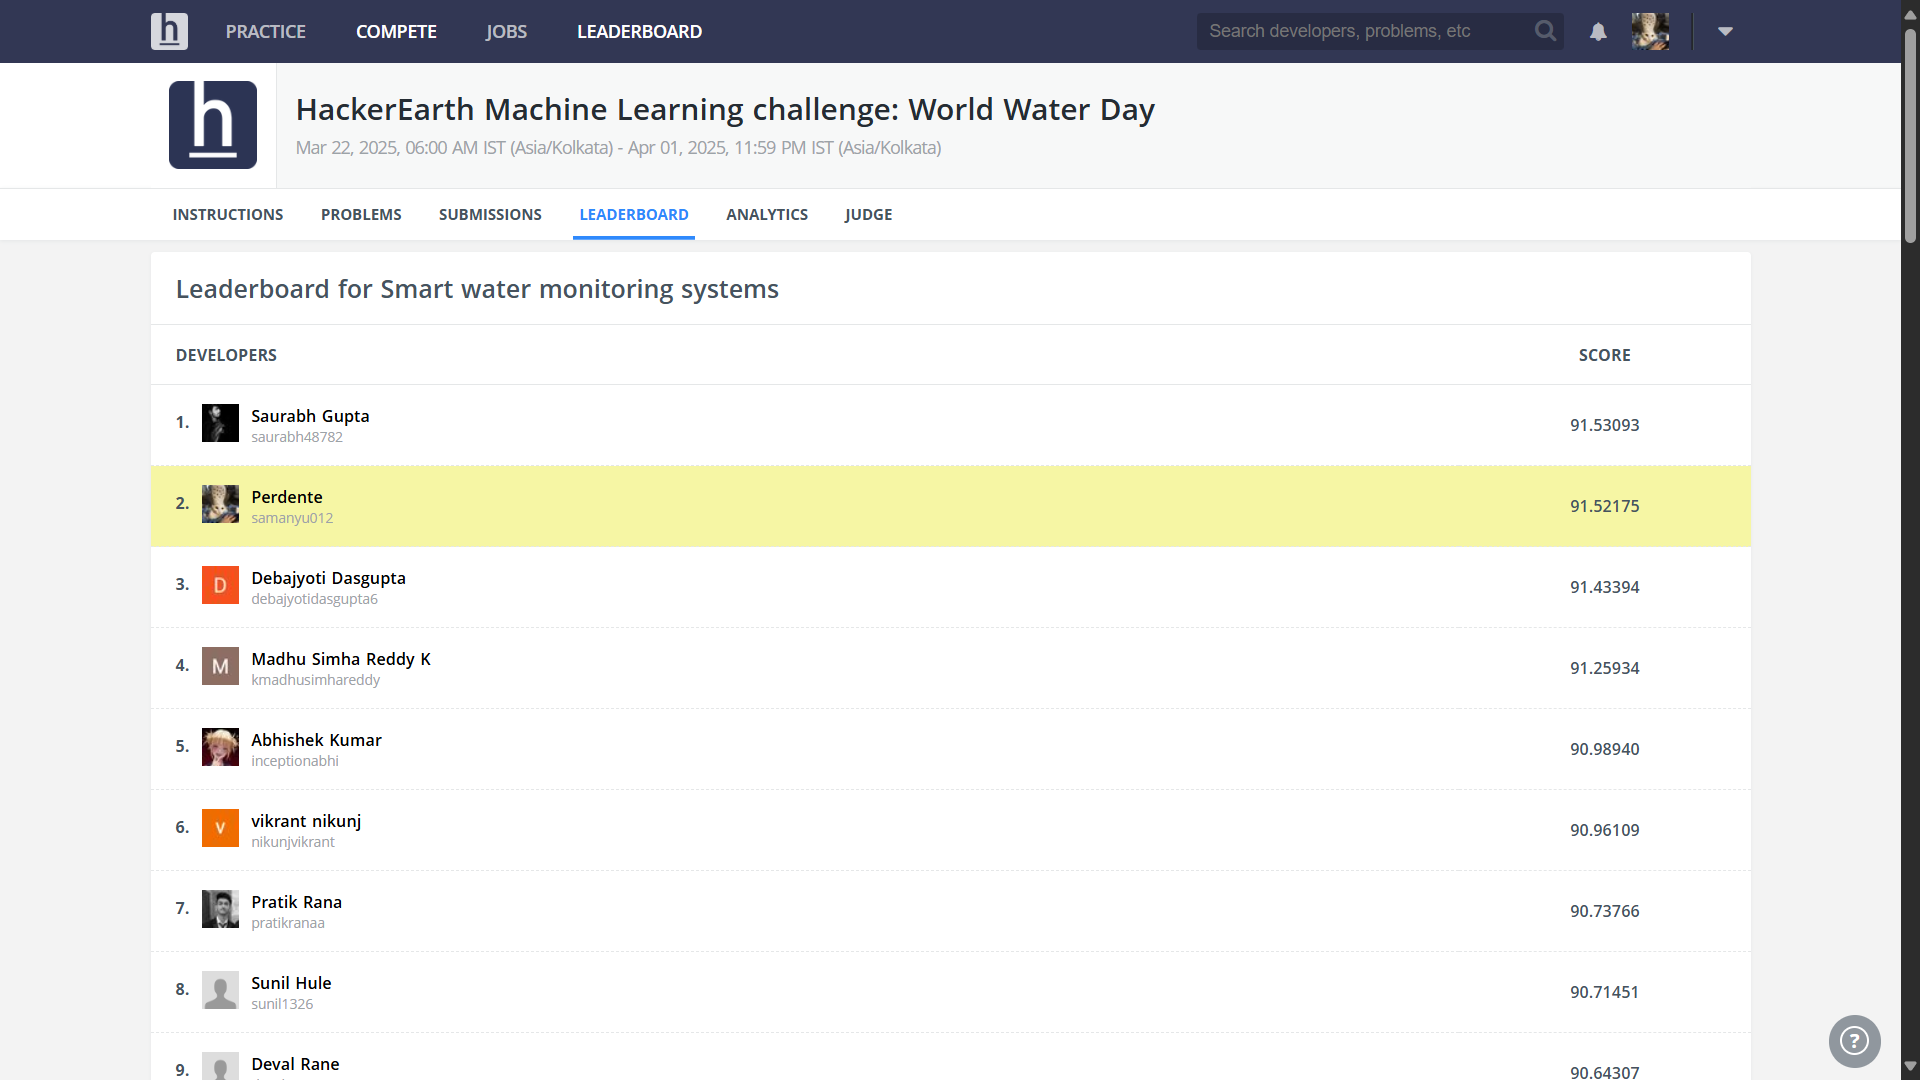
